In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import os
print( os.getcwd() )

/Users/austinclime/vs_code_projects/vix_approx/vix_approx_research/VIX_SKEW_replication


In [5]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import pyarrow as pa
#import pyarrow.parquet as pq
#import pyarrow.csv as pv

from io import StringIO
from datetime import timedelta
import pytz
import datetime

#import pandas_datareader.data as web
import pandas_market_calendars as mcal
from scipy.interpolate import CubicSpline, interp1d

import matplotlib.dates as mdates

In [6]:
path='https://cdn.cboe.com/api/global/us_indices/daily_prices/VIX_History.csv'
vix_hist=pd.read_csv(path,index_col='DATE')
vix_hist.index = pd.to_datetime(vix_hist.index)
vix_hist.index = vix_hist.index.strftime('%Y-%m-%d')
display(vix_hist.head(2))
path='https://cdn.cboe.com/api/global/us_indices/daily_prices/SKEW_History.csv'
skew_hist=pd.read_csv(path,index_col='DATE')
skew_hist.index = pd.to_datetime(skew_hist.index)
skew_hist.index = skew_hist.index.strftime('%Y-%m-%d')
display(skew_hist.head(2))

,OPEN,HIGH,LOW,CLOSE
DATE,,,,
1990-01-02,17.24,17.24,17.24,17.24
1990-01-03,18.19,18.19,18.19,18.19


,SKEW
DATE,
1990-01-02,126.09
1990-01-03,123.34


In [7]:
vixmo_data_df=pd.read_csv('options_vixmo_data.csv')
#vixmo_data_df['CALCULATION_TIME']=pd.to_datetime(vixmo_data_df['CALCULATION_TIME'])
vixmo_data_df['CALCULATION_DATE']=vixmo_data_df.CALCULATION_TIME.str.split(' ').str[0]
#vixmo_data_df.groupby(['CALCULATION_DATE','TERM'])
skew_vixmo_df=pd.read_csv('skew_calc_vixmo_data.csv')

skew_vixmo_df.rename(columns={'trade_date':'CALCULATION_DATE'},inplace=True)
skew_vixmo_df.set_index('CALCULATION_DATE',inplace=True)
skew_vixmo_df.index = pd.to_datetime(skew_vixmo_df.index)
skew_vixmo_df.index = skew_vixmo_df.index.strftime('%Y-%m-%d')

skew_weights=skew_vixmo_df[['near_term_weight','next_term_weight']].reset_index()
skew_weights.rename(columns={'near_term_weight':'near',	'next_term_weight':'next'},inplace=True)
skew_weights=skew_weights.set_index('CALCULATION_DATE').stack().reset_index(level=-1).rename(columns={'level_1':'TERM',0:'weight'}).reset_index()
vixmo_data_df=vixmo_data_df.merge(skew_weights,how='left',on=['CALCULATION_DATE','TERM']).rename(columns={'weight':'term_weight'})

/var/folders/nr/239fpjgn5zg829rq2drl_2kw0000gn/T/ipykernel_25567/194673675.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  skew_vixmo_df.index = pd.to_datetime(skew_vixmo_df.index)


In [11]:
def index_computation(truncation_condition=None):

    def skew_weights_1(slice):
        mins_30_days=30*60*24
        slice1=slice[slice.TERM=='near']
        slice2=slice[slice.TERM=='next']
        w=(slice2.MIN_TO_EXPIRE.unique()[0]-mins_30_days)
        w/=(slice2.MIN_TO_EXPIRE.unique()[0]-slice1.MIN_TO_EXPIRE.unique()[0])
        return [w,1-w]

    def portfolio_constructors(slice):
        F=slice.FORWARD_PRICE.unique()[0]
        K0=slice.K0_SELECTION.unique()[0]
        calls=slice[slice.STRIKE_PRICE>K0]
        puts=slice[slice.STRIKE_PRICE<K0]
        pca=pd.DataFrame.from_dict({'STRIKE_PRICE':K0,
                                'CALL_PUT_FLAG':'P/C Avg', #put-call average
                                'midprice':slice[(slice.STRIKE_PRICE==K0)]['midprice'].mean(),
                                'INTEREST_RATE':slice.INTEREST_RATE,
                                'YEARS_TO_EXPIRE':slice.YEARS_TO_EXPIRE} ).head(1)
        opt_portfolio=pd.concat([puts,pca,calls],ignore_index=True)[['STRIKE_PRICE','CALL_PUT_FLAG','midprice','INTEREST_RATE','YEARS_TO_EXPIRE']]
        #opt_portfolio=pd.concat([puts,calls],ignore_index=True)[['STRIKE_PRICE','CALL_PUT_FLAG','midprice','INTEREST_RATE','YEARS_TO_EXPIRE']]
        opt_portfolio['dK']=(opt_portfolio.STRIKE_PRICE.shift(-1)-opt_portfolio.STRIKE_PRICE.shift(1))/2
        opt_portfolio.loc[0,'dK']=opt_portfolio.iloc[1]['STRIKE_PRICE']-opt_portfolio.iloc[0]['STRIKE_PRICE']
        opt_portfolio.loc[opt_portfolio.index[-1],'dK']=opt_portfolio.iloc[-1]['STRIKE_PRICE']-opt_portfolio.iloc[-2]['STRIKE_PRICE']
        
        #Truncating the portfolio
        opt_portfolio['moneyness_pct']=F/opt_portfolio['STRIKE_PRICE']-1
        opt_portfolio['z_moneyness']=(opt_portfolio['moneyness_pct']-opt_portfolio['moneyness_pct'].mean()) / opt_portfolio['moneyness_pct'].std() 
        #opt_portfolio=opt_portfolio[ (abs(opt_portfolio.z_moneyness)<=2) ]
        #opt_portfolio=opt_portfolio[ (opt_portfolio.z_moneyness<=2) ]
        #opt_portfolio=opt_portfolio[ abs(opt_portfolio.moneyness_pct<=0.1) ]
        if truncation_condition:
            opt_portfolio=opt_portfolio.query(truncation_condition)
        #display(opt_portfolio)
        #print(5/0)

        r,t=opt_portfolio.INTEREST_RATE.unique()[0],opt_portfolio.YEARS_TO_EXPIRE.unique()[0]
        
        #CBOE SKEW
        e1=-(1+np.log(F/K0)-(F/K0))
        e2=2*np.log(K0/F)*(F/K0-1)+(1/2)*np.log(K0/F)**2
        e3=3*np.log(K0/F)**2 * (1/3*np.log(K0/F)-1+F/K0)
        p1_option_weight=-opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
        p2_option_weight=2*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
        p2_option_weight*=1-np.log(opt_portfolio.STRIKE_PRICE/F)
        p3_option_weight=3*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
        p3_option_weight*=2*np.log(opt_portfolio.STRIKE_PRICE/F)-np.log(opt_portfolio.STRIKE_PRICE/F)**2
        
        P1=( np.exp(r*t)*(opt_portfolio.midprice*p1_option_weight) ).sum()
        P1+=e1
        P2=( np.exp(r*t)*(opt_portfolio.midprice*p2_option_weight) ).sum()
        P2+=e2
        P3=( np.exp(r*t)*(opt_portfolio.midprice*p3_option_weight) ).sum()
        P3+=e3
        S=P3-3*P1*P2+2*P1**3
        S/=(P2-P1**2)**(3/2)
        
        #METHOD2
        sigma=np.sqrt(P2-P1**2)#**0.5
        S_method2=6/sigma**3 * (np.exp(-P1-0.5*sigma**2)-1)
        #display(opt_portfolio.iloc[277-3:277+3])
        #print(5/0)
        #Carr-Madan
        
        #METHOD3
        #"""
        correction_term=(1/t)*(F/K0-1)**2
        VIX_opt_weight=2*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
        SVIX_opt_weight=2*opt_portfolio.dK/(F**2)
        VIX_square=( np.exp(r*t)*(opt_portfolio.midprice*VIX_opt_weight) ).sum()
        SVIX_square=( np.exp(r*t)*(opt_portfolio.midprice*SVIX_opt_weight) ).sum()
        #VIX_square+=correction_term
        #SVIX_square+=correction_term
        sigma=np.sqrt(P2-P1**2)#**0.5
        S_method3=3/2*(SVIX_square-VIX_square)/ sigma**3#+3/2*np.sqrt(VIX_square)
        #"""
        #COMPRIMISE SKEW

        #METHOD 4
        MartinSKEW_opt_weight=6*(opt_portfolio.STRIKE_PRICE-F)*opt_portfolio.dK/(F**3)
        MartinSKEW_opt_weight/=sigma**3
        S_method4=( np.exp(r*t)*(opt_portfolio.midprice*MartinSKEW_opt_weight) ).sum()
        return [S,S_method2,S_method3,VIX_square,SVIX_square,P1,P2,S_method4] #.unique()[0]

    term_rep_df=pd.DataFrame(vixmo_data_df.groupby(['CALCULATION_DATE','TERM']).apply(portfolio_constructors),columns=['Replicates'])
    term_rep_df['S_rep']=term_rep_df['Replicates'].apply(lambda x:x[0])
    term_rep_df['S_method2']=term_rep_df['Replicates'].apply(lambda x:x[1])
    term_rep_df['S_method3']=term_rep_df['Replicates'].apply(lambda x:x[2])
    term_rep_df['VIX^2']=term_rep_df['Replicates'].apply(lambda x:x[3])
    term_rep_df['SVIX^2']=term_rep_df['Replicates'].apply(lambda x:x[4])
    term_rep_df['P1']=term_rep_df['Replicates'].apply(lambda x:x[5])
    term_rep_df['P2']=term_rep_df['Replicates'].apply(lambda x:x[6])
    term_rep_df['S_method4']=term_rep_df['Replicates'].apply(lambda x:x[7])
    term_rep_df.drop(['Replicates'],axis=1,inplace=True)
    term_rep_df

    w_rep=pd.DataFrame( vixmo_data_df.groupby(['CALCULATION_DATE']).apply(skew_weights_1) ,columns=['w'])
    w_rep['TERM']=[ ['near','next'] for i in w_rep.index]
    w_rep=w_rep.explode(['TERM','w'])
    w_rep.set_index('TERM', append=True, inplace=True)
    SKEW_rep_1=w_rep.join(term_rep_df,how='inner')
    SKEW_rep_1['weighted_S']=SKEW_rep_1['S_rep']*SKEW_rep_1['w']
    SKEW_rep_1=100-10*SKEW_rep_1.groupby(SKEW_rep_1.index.get_level_values(0))['weighted_S'].sum()
    SKEW_check_1=skew_vixmo_df['skew_level']-SKEW_rep_1
    #print('SKEW accuracy check')
    #display(SKEW_check_1[abs(SKEW_check_1)>= (10**-7) ])

    SKEW_rep_2=w_rep.join(term_rep_df,how='inner')
    SKEW_rep_2['weighted_S']=SKEW_rep_2['S_rep']*SKEW_rep_2['w']
    SKEW_rep_2['weighted_S_method2']=SKEW_rep_2['S_method2']*SKEW_rep_2['w']
    SKEW_rep_2['weighted_S_method3']=SKEW_rep_2['S_method3']*SKEW_rep_2['w']
    SKEW_rep_2['weighted_S_method4']=SKEW_rep_2['S_method4']*SKEW_rep_2['w']
    #taking away 100-10 scaling
    #SKEW_rep_2=100-10*SKEW_rep_2.groupby(SKEW_rep_2.index.get_level_values(0))[['weighted_S','weighted_S_method2','weighted_S_method3']].sum()
    SKEW_rep_2=SKEW_rep_2.groupby(SKEW_rep_2.index.get_level_values(0))[['weighted_S','weighted_S_method2','weighted_S_method3','weighted_S_method4']].sum()
    SKEW_rep_2.rename(columns={'weighted_S':'CBOE_SKEW',
                            'weighted_S_method2':'SKEW_method2',
                            'weighted_S_method3':'SKEW_method3',
                            'weighted_S_method4':'SKEW_method4'},inplace=True)
    SKEW_rep_2[['CBOE_SKEW_chg','SKEW_method2_chg','SKEW_method3_chg','SKEW_method4_chg']]=SKEW_rep_2/SKEW_rep_2.shift(1)-1
    #SKEW_rep_2.index=pd.to_datetime(SKEW_rep_2.index)
    SKEW_rep_2#.to_csv('SKEW_formula_replciates.csv')

    #cboe_df=pd.DataFrame(vixmo_data_df.groupby(['CALCULATION_DATE','TERM'])[['P1','P2','P3','S']].mean())
    #cboe_df.columns=[i+'_CBOE' for i in cboe_df.columns]
    #cboe_df

    #merged_df=term_rep_df.join(cboe_df,how='inner')
    #merged_df['P1_error']=abs(merged_df['P1_UMD']-merged_df['P1_CBOE'])
    #merged_df['P2_error']=abs(merged_df['P2_UMD']-merged_df['P2_CBOE'])
    #merged_df['P3_error']=abs(merged_df['P3_UMD']-merged_df['P3_CBOE'])
    #merged_df['S_error']=abs(merged_df['S_rep']-merged_df['S_CBOE'])
    #merged_df#.to_csv('VIXMO_Replication_UMD.csv')
    #merged_df[['P1_error','P2_error','P3_error','S_error']].describe()

    #term_rep_df
    return SKEW_rep_2,term_rep_df,w_rep

SKEW_rep_2,term_rep_df,w_rep=index_computation(truncation_condition=None)
#cond='abs(moneyness_pct<=0.1)'
#cond='abs(moneyness_pct<=0.15)'
#display( index_computation(truncation_condition=cond) )

In [12]:
skew_check=SKEW_rep_2[['CBOE_SKEW']].join(skew_hist)
skew_check.rename(columns={'CBOE_SKEW':'Replicated','SKEW':'Actual'},inplace=True)
skew_check['Replicated']=100-10*skew_check['Replicated']
skew_check['Replicated']=skew_check['Replicated'].astype(float)
print('Correlation Levels')
display(skew_check.corr())
#skew_check=pd.to_numeric(skew_check)
#skew_check.dtypes
skew_check=skew_check.round(2)
skew_check['error']=(skew_check['Replicated']/skew_check['Actual'])-1
print('% errors (replicated/actual-1)')
skew_check['error'].describe()

Correlation Levels


,Replicated,Actual
Replicated,1.000000,0.999999
Actual,0.999999,1.000000


% errors (replicated/actual-1)


count    7.600000e+01
mean    -5.533036e-07
std      6.607649e-05
min     -2.073112e-04
25%      0.000000e+00
50%      0.000000e+00
75%      1.444753e-05
max      1.279754e-04
Name: error, dtype: float64

In [410]:
SKEW_rep_3=SKEW_rep_2.reset_index()
SKEW_rep_3['CALCULATION_DATE']=pd.to_datetime(SKEW_rep_3['CALCULATION_DATE'])
SKEW_rep_3.set_index(['CALCULATION_DATE'],inplace=True)

SKEW_rep_4=SKEW_rep_3.copy()
SKEW_rep_4[['CBOE_SKEW','SKEW_method2','SKEW_method3']]=100-10*SKEW_rep_4[['CBOE_SKEW','SKEW_method2','SKEW_method3']]

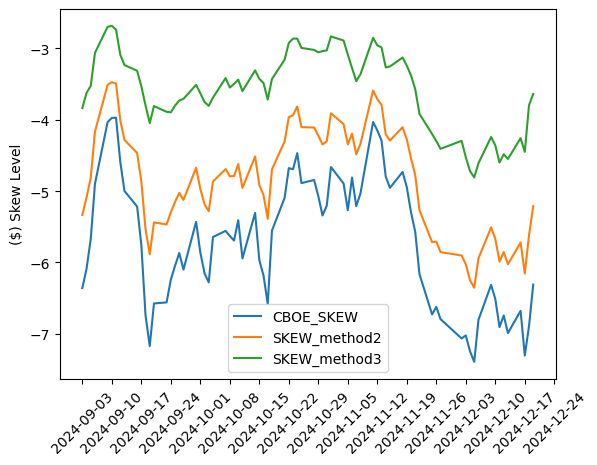

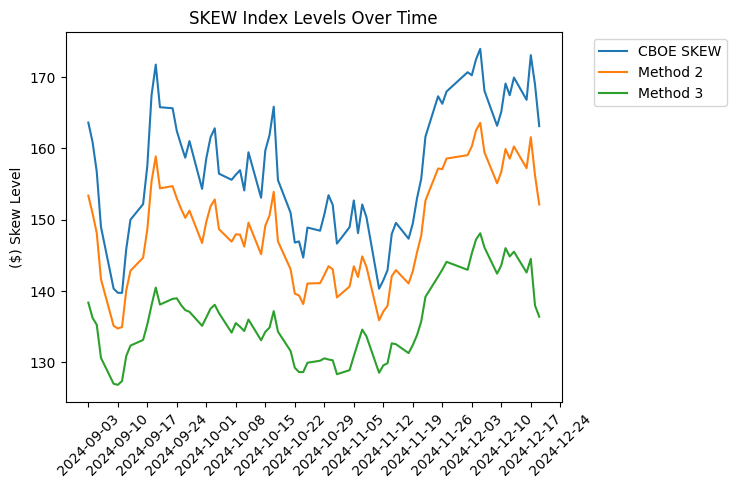

In [722]:
#plt.plot(SKEW_rep_2.index,
fig, ax = plt.subplots()
plt.plot( SKEW_rep_3[['CBOE_SKEW','SKEW_method2','SKEW_method3']] ,label=['CBOE_SKEW','SKEW_method2','SKEW_method3'] )

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.ylabel('($) Skew Level')
plt.legend()
plt.show()
###########################################################################
fig, ax = plt.subplots()
plt.title('SKEW Index Levels Over Time')
plt.plot( SKEW_rep_4[['CBOE_SKEW','SKEW_method2','SKEW_method3']] ,label=['CBOE SKEW','Method 2','Method 3'] )

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.ylabel('($) Skew Level')
#plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


In [412]:
skew_correlation=pd.DataFrame.from_dict({'No_Truncation':[0*i for i in range(2,5+1)],
                        '10%_OOM_Truncation':[0*i for i in range(2,5+1)],
                        '15%_OOM_Truncation':[0*i for i in range(2,5+1)]},
                        orient='index',columns=['CBOE']+['Method'+str(i) for i in range(2,4+1)])

skew_correlation

conditions=[None,'abs(moneyness_pct<=0.1)','abs(moneyness_pct<=0.15)']
counter=0
for condition in conditions:
    SKEW_rep_trunc,term_rep_df,w_rep=index_computation(truncation_condition=condition)
    skew_correlation.iloc[counter,:]=SKEW_rep_trunc.corr().iloc[0,:4]
    counter+=1
    

Text(0.5, 1.0, 'Correlation with CBOE SKEW')

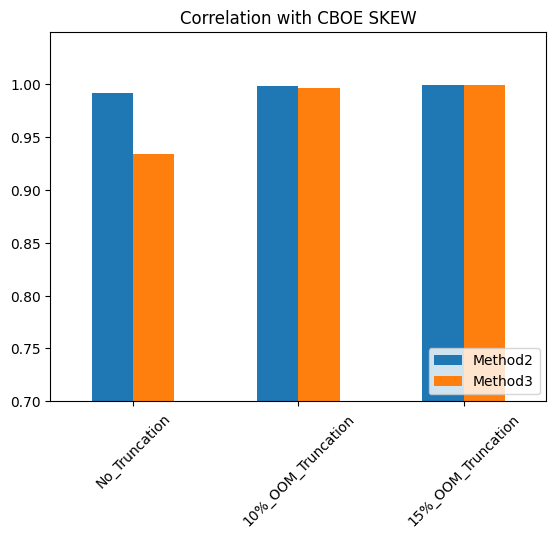

In [413]:
skew_correlation.iloc[:,1:]
ax=skew_correlation.iloc[:,1:-1].plot.bar(rot=45)
ax.legend(loc=4)
ax.set_ylim(0.7,None)
ax.set_title('Correlation with CBOE SKEW')


In [414]:
display( SKEW_rep_2.corr().iloc[:3,:3] )
display( SKEW_rep_2.corr().iloc[-4:-1,-4:-1] )

,CBOE_SKEW,SKEW_method2,SKEW_method3
CBOE_SKEW,1.000000,0.991714,0.933887
SKEW_method2,0.991714,1.000000,0.971660
SKEW_method3,0.933887,0.971660,1.000000


,CBOE_SKEW_chg,SKEW_method2_chg,SKEW_method3_chg
CBOE_SKEW_chg,1.000000,0.985519,0.854128
SKEW_method2_chg,0.985519,1.000000,0.927057
SKEW_method3_chg,0.854128,0.927057,1.000000


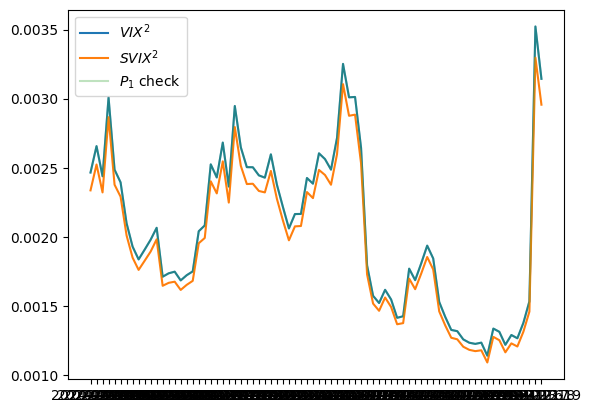

In [421]:
VIX_check=w_rep.join(term_rep_df,how='inner')
VIX_check['weighted_VIX^2']=VIX_check['VIX^2']*VIX_check['w']
VIX_check['weighted_SVIX^2']=VIX_check['SVIX^2']*VIX_check['w']
VIX_check['weighted_P1']=VIX_check['P1']*VIX_check['w']
VIX_check_2=VIX_check.groupby(VIX_check.index.get_level_values(0))[['weighted_VIX^2','weighted_SVIX^2','weighted_P1']].sum()
#VIX_check_2['VIX']=np.sqrt(VIX_check_2['weighted_VIX'].astype(float))*100
plt.plot(VIX_check_2.index,VIX_check_2['weighted_VIX^2'],label='$VIX^2$')
plt.plot(VIX_check_2.index,VIX_check_2['weighted_SVIX^2'],label='$SVIX^2$')
plt.plot(VIX_check_2.index,-2*VIX_check_2['weighted_P1'],label='$P_1$ check',alpha=0.3)
plt.legend()
plt.show()

In [185]:
#display(SKEW_rep_2)
#display(SKEW_rep_3)

Mean Relative Level


CBOE_SKEW            1.0
SKEW_method2    0.850747
SKEW_method3     0.62963
SKEW_method4   -2.311268
dtype: object

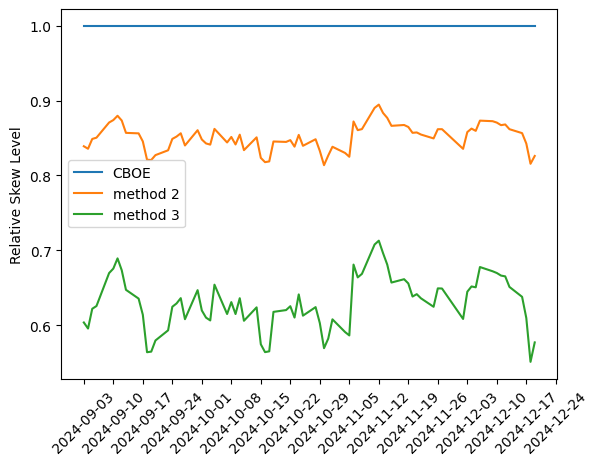

In [422]:
x=SKEW_rep_3[['CBOE_SKEW','SKEW_method2','SKEW_method3','SKEW_method4']]
x=x.copy()
x['SKEW_method2']=x['SKEW_method2']/x['CBOE_SKEW']
x['SKEW_method3']=x['SKEW_method3']/x['CBOE_SKEW']
#x['SKEW_method4']=x['SKEW_method4']/x['CBOE_SKEW']
x['CBOE_SKEW']/=x['CBOE_SKEW']
print('Mean Relative Level')
display(x.mean())

fig, ax = plt.subplots()
plt.plot(x.index,x.CBOE_SKEW,label='CBOE')
plt.plot(x.index,x.SKEW_method2,label='method 2')
plt.plot(x.index,x.SKEW_method3,label='method 3') #simple skew

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.ylabel('Relative Skew Level')

#plt.plot(x.index,x.SKEW_method4,label='method 4') 
plt.legend()
plt.show()


In [193]:
#dont set returns lower than this
#day_df.STRIKE_PRICE.min()/F-1
#min(spotS_T)

# Payoff Graph

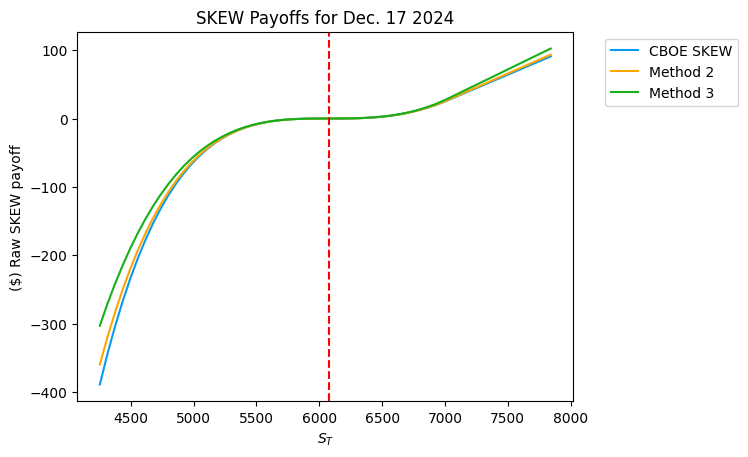

In [723]:
my_day='2024-12-17'
#my_day='2024-10-08'
day_df=vixmo_data_df[(vixmo_data_df.CALCULATION_DATE==my_day) &
                     (vixmo_data_df.TERM=='near') ]
F=day_df.FORWARD_PRICE.unique()[0]

#day_df_2=vixmo_data_df[(vixmo_data_df.CALCULATION_DATE==my_day) &
#                     (vixmo_data_df.TERM=='next') ]

#mins_30_days=30*60*24
#w=(day_df_2.MIN_TO_EXPIRE.unique()[0]-mins_30_days)
#w/=(day_df_2.MIN_TO_EXPIRE.unique()[0]-day_df.MIN_TO_EXPIRE.unique()[0])

def option_portfolio_payoffs(day_df,ST,truncation_condition):
    #truncation_condition=None

    F=day_df.FORWARD_PRICE.unique()[0]
    K0=day_df.K0_SELECTION.unique()[0]
    calls=day_df[day_df.STRIKE_PRICE>K0]
    puts=day_df[day_df.STRIKE_PRICE<K0]
    pca=pd.DataFrame.from_dict({'STRIKE_PRICE':K0,
                            'CALL_PUT_FLAG':'P/C Avg', #put-call average
                            'midprice':day_df[(day_df.STRIKE_PRICE==K0)]['midprice'].mean(),
                            'INTEREST_RATE':day_df.INTEREST_RATE,
                            'YEARS_TO_EXPIRE':day_df.YEARS_TO_EXPIRE} ).head(1)
    opt_portfolio=pd.concat([puts,pca,calls],ignore_index=True)[['STRIKE_PRICE','CALL_PUT_FLAG','midprice','INTEREST_RATE','YEARS_TO_EXPIRE']]
    #opt_portfolio=pd.concat([puts,calls],ignore_index=True)[['STRIKE_PRICE','CALL_PUT_FLAG','midprice','INTEREST_RATE','YEARS_TO_EXPIRE']]
    opt_portfolio['dK']=(opt_portfolio.STRIKE_PRICE.shift(-1)-opt_portfolio.STRIKE_PRICE.shift(1))/2
    opt_portfolio.loc[0,'dK']=opt_portfolio.iloc[1]['STRIKE_PRICE']-opt_portfolio.iloc[0]['STRIKE_PRICE']
    opt_portfolio.loc[opt_portfolio.index[-1],'dK']=opt_portfolio.iloc[-1]['STRIKE_PRICE']-opt_portfolio.iloc[-2]['STRIKE_PRICE']

    #Truncating the portfolio
    opt_portfolio['moneyness_pct']=F/opt_portfolio['STRIKE_PRICE']-1
    opt_portfolio['z_moneyness']=(opt_portfolio['moneyness_pct']-opt_portfolio['moneyness_pct'].mean()) / opt_portfolio['moneyness_pct'].std() 

    opt_portfolio['option_payoff']=np.where(opt_portfolio['CALL_PUT_FLAG']=='C', 
                                            np.where(opt_portfolio.STRIKE_PRICE<=ST,ST-opt_portfolio.STRIKE_PRICE,0), 
                                            np.where(opt_portfolio.STRIKE_PRICE>=ST,opt_portfolio.STRIKE_PRICE-ST,0) )

    if truncation_condition:
        opt_portfolio=opt_portfolio.query(truncation_condition)

    r,t=opt_portfolio.INTEREST_RATE.unique()[0],opt_portfolio.YEARS_TO_EXPIRE.unique()[0]
    #t=0
    #CBOE SKEW
    e1=-(1+np.log(F/K0)-(F/K0))
    e2=2*np.log(K0/F)*(F/K0-1)+(1/2)*np.log(K0/F)**2
    e3=3*np.log(K0/F)**2 * (1/3*np.log(K0/F)-1+F/K0)
    p1_option_weight=-opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
    p2_option_weight=2*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
    p2_option_weight*=1-np.log(opt_portfolio.STRIKE_PRICE/F)
    p3_option_weight=3*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
    p3_option_weight*=2*np.log(opt_portfolio.STRIKE_PRICE/F)-np.log(opt_portfolio.STRIKE_PRICE/F)**2

    P1=( np.exp(r*t)*(opt_portfolio.midprice*p1_option_weight) ).sum()
    P1+=e1
    P2=( np.exp(r*t)*(opt_portfolio.midprice*p2_option_weight) ).sum()
    P2+=e2
    P3=( np.exp(r*t)*(opt_portfolio.midprice*p3_option_weight) ).sum()
    P3+=e3
    S=P3-3*P1*P2+2*P1**3
    sigma=np.sqrt(P2-P1**2)
    S/=sigma**3

    t=0
    P3_payoff = ( np.exp(r*0)*(opt_portfolio.option_payoff*p3_option_weight) ).sum()
    P2_payoff = ( np.exp(r*0)*(opt_portfolio.option_payoff*p2_option_weight) ).sum()
    P1_payoff = ( np.exp(r*0)*(opt_portfolio.option_payoff*p1_option_weight) ).sum()
    method1_payoff = (P3_payoff-3 * P1*P2_payoff + 2*P1**2 * P1_payoff) / sigma**3

    #METHOD2
    S_method2=6 * (np.exp(-P1-0.5*sigma**2)-1)
    S_method2/=sigma**3
    
    method2_payoff=(-6*P1_payoff - 3*P2_payoff) / sigma**3

    #METHOD3
    #"""
    #correction_term=(1/t)*(F/K0-1)**2
    VIX_opt_weight=2*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
    SVIX_opt_weight=2*opt_portfolio.dK/(F**2)
    VIX_square=( np.exp(r*t)*(opt_portfolio.option_payoff*VIX_opt_weight) ).sum()
    SVIX_square=( np.exp(r*t)*(opt_portfolio.option_payoff*SVIX_opt_weight) ).sum()
    #VIX_square+=correction_term
    #SVIX_square+=correction_term
    S_method3=3/2*(SVIX_square-VIX_square)
    S_method3/= sigma**3
    #"""
    method3_payoff = 3/2*(SVIX_square-VIX_square) / (sigma**3)


    #METHOD 4
    MartinSKEW_opt_weight=6*(opt_portfolio.STRIKE_PRICE-F)*opt_portfolio.dK/(F**3)
    MartinSKEW_opt_weight/=sigma**3
    S_method4=( np.exp(r*t)*(opt_portfolio.midprice*MartinSKEW_opt_weight) ).sum()
    
    method4_payoff = (np.exp(ST/F-1)-1)**3 / (sigma**3)

    #return sigma
    #return S,S_method2,S_method3,S_method4
    #return VIX_square,SVIX_square,P1_payoff
    return method1_payoff,method2_payoff,method3_payoff,method4_payoff
    #return VIX_square,P1_payoff-2*(ST/F-1)
    #return P1_payoff + (ST/F-1), np.log(ST/F)

    #return method1_payoff, ( np.log(ST/F)-P1 )**3 / (sigma**3)
    #return method2_payoff, ( 6*(ST/F-1)-6*np.log(ST/F)-3*np.log(ST/F)**2 )/ (sigma**3)
    #return method3_payoff, 3/2 * ( (ST/F-1)**2 + 2*np.log(ST/F)-2*ST/F+2 )/ (sigma**3)



spotS_T=np.array([F*(1+0.01*i) for i in range(-30,30)])
#spotS_T=np.array([F*(1+0.01*i) for i in range(-1_000,1_000)])
#spotS_T=np.where(spotS_T<=0,0,spotS_T)
#spotS_T=np.array([1+0.02*i for i in range(-20,20)])

#SKEW_payoff=( (np.log(spotS_T)-P1)/ np.sqrt(P2-P1**2) )**3

truncation_condition=None
#truncation_condition='abs(moneyness_pct<=0.05)'

######################__Portfolio Payoffs__######################
SKEW_payoff=np.array( [option_portfolio_payoffs(day_df,s,truncation_condition)[0] for s in spotS_T] )
SKEW_Method2_payoff=np.array( [option_portfolio_payoffs(day_df,s,truncation_condition)[1] for s in spotS_T] )
SKEW_Method3_payoff=np.array( [option_portfolio_payoffs(day_df,s,truncation_condition)[2] for s in spotS_T] )
#SKEW_Method4_payoff=np.array( [option_portfolio_payoffs(day_df,s,truncation_condition)[3] for s in spotS_T] )                            
plt.plot(spotS_T,SKEW_payoff,label='CBOE SKEW',c='#069AF3')
plt.plot(spotS_T,SKEW_Method2_payoff,label='Method 2',c='orange')
plt.plot(spotS_T,SKEW_Method3_payoff,label='Method 3',c='#15B01A')
#plt.plot(spotS_T,SKEW_Method4_payoff,label='Method4',c='r')
plt.title('SKEW Payoffs for Dec. 17 2024')
plt.xlabel('$S_T$')
plt.ylabel('($) Raw SKEW payoff')

######################__P1 Check__######################
#VIX_square_payoff=np.array( [option_portfolio_payoffs(day_df,s,truncation_condition)[0] for s in spotS_T] )
#SVIX_square_payoff=np.array( [option_portfolio_payoffs(day_df,s,truncation_condition)[1] for s in spotS_T] )
#P1_payoff=-2*np.array( [option_portfolio_payoffs(day_df,s,truncation_condition)[2] for s in spotS_T] )
#P1_payoff=np.array( [option_portfolio_payoffs(day_df,s,truncation_condition)[2] for s in spotS_T] )
#plt.plot(spotS_T,VIX_square_payoff,label='$VIX^2$')
#plt.plot(spotS_T,SVIX_square_payoff,label='$SVIX^2$')
#plt.plot(spotS_T,(P1_payoff + (spotS_T/F-1) ),label='my calc')
#plt.plot(spotS_T, np.log(spotS_T/F),label='check')
#plt.title('$VIX^2$ and $SVIX^2$ Payoffs')
#plt.xlabel('$S_T$')

#sigma_payoff=np.array( [option_portfolio_payoffs(day_df,s,truncation_condition) for s in spotS_T] )
#plt.plot(spotS_T,sigma_payoff,label='$\sigma$')

######################__Power Payoff Verification__######################
#my_calc=np.array( [option_portfolio_payoffs(day_df,s,truncation_condition)[0] for s in spotS_T] )
#check=np.array( [option_portfolio_payoffs(day_df,s,truncation_condition)[1] for s in spotS_T] )
#plt.title('Method 3 Payoff')
#plt.plot(spotS_T,my_calc,label=r'$\frac{SVIX^2-VIX^2}{\sigma^3}$')
#plt.plot(spotS_T,check,label=r'$\frac{3}{2} \frac{(S_T/F-1)^2 + 2\log(S_T/F)-2S_T/F+2)}{\sigma^3}$')
#-
#plt.title('Method 2 Payoff')
#plt.plot(spotS_T,my_calc,label=r'$\frac{-6P_1-3P_2}{\sigma^3}$')
#plt.plot(spotS_T,check,label=r'$\frac{6(S/F-1)-6\log(S/F)-3\log^2(S/F)}{\sigma^3}$')
#-
#plt.title('Method 1 Payoff')
#plt.plot(spotS_T,my_calc,label=r'$\frac{P_3-3P_1P_2+2P_1^3}{\sigma^3}$')
#plt.plot(spotS_T,check,label=r'$\frac{\log(S/F)-P_1^3}{\sigma^3}$')


#P1_calc,P2_calc,P3_calc=option_portfolio_payoffs(day_df,100,truncation_condition)

#plt.axvline(x=day_df.STRIKE_PRICE.min(),color='b', linestyle='--')
#plt.axvline(x=day_df.STRIKE_PRICE.max(),color='b', linestyle='--')
plt.axvline(x=F,color='r', linestyle='--')
#plt.legend(loc='lower right')
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

In [721]:
print( vixmo_data_df.CALCULATION_DATE.min() )
print( vixmo_data_df.CALCULATION_DATE.max() )

2024-09-03
2024-12-19


In [190]:
#print(F)

#np.where(np.diff(SKEW_payoff)<0)[0][-1]
#print(spotS_T[np.where(np.diff(SKEW_payoff)<0)[0][-2]])
#print(spotS_T[np.where(np.diff(SKEW_payoff)<0)[0][-1]])
#print(spotS_T[np.where(np.diff(SKEW_payoff)<0)[0][-1]+1])
#day_df.STRIKE_PRICE.describe()

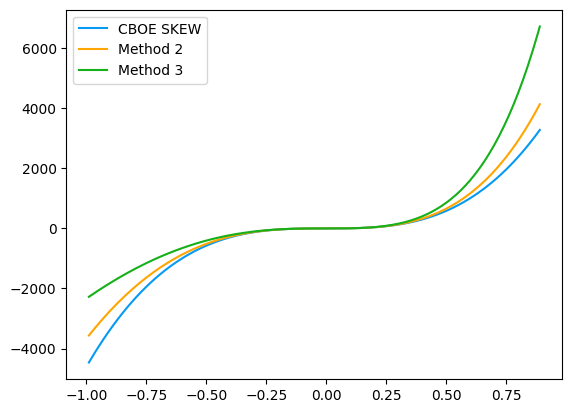

In [424]:
#cboeskew spreadhseet
P1=-0.00173
P2=0.003606
sigma=(P2-P1**2)**0.5
P3=-2.19656*sigma**3 - 2*P1**3 + 3*P1*P2

R=np.arange(-0.99,0.9,0.01)
#R=np.arange(-0.2,0.2,0.01)
CBOE_SKEW=((R-P1)/sigma)**3
METHOD_2=(6*np.exp(R) - 6-3*R**2-6*R) / (sigma**3)
METHOD_3=3/2*((np.exp(R)-1)**2 + 2*R-2*(np.exp(R)-1)) / (sigma**3)
METHOD_4=(np.exp(R)-1)**3 / (sigma**3)
plt.plot(R,CBOE_SKEW,label='CBOE SKEW',c='#069AF3')
plt.plot(R,METHOD_2,label='Method 2',c='orange')
plt.plot(R,METHOD_3,label='Method 3',c='#15B01A')
#plt.plot(R,METHOD_4,label='Method 4',c='r')
plt.legend()
plt.show()


# Bid-Ask Spread Analysis

In [37]:
vixmo_data_df.columns

Index(['SYMBOL_ID', 'INDEX_ID', 'CALCULATION_TIME', 'RESULT', 'RAW_RESULT',
       'TERM', 'INTEREST_RATE', 'K0_SELECTION', 'FORWARD_PRICE',
       'MIN_TO_EXPIRE', 'INSTRUMENT_ID', 'SYMBOL', 'EXPIRE_DATE',
       'STRIKE_PRICE', 'CALL_PUT_FLAG', 'BID_PRICE', 'ASK_PRICE',
       'STRIKE_PRICE_WEIGHT', 'STRIKE_PRICE_CONTRIBUTION', 'TRADE_DT',
       'HEALTHY', 'PREV_VALUE', 'midprice', 'YEARS_TO_EXPIRE', 'p1_contr',
       'p2_contr', 'p3_contr', 'series_count', 'P1', 'P2', 'P3', 'S',
       'CALCULATION_DATE'],
      dtype='object')

In [265]:
my_day='2024-12-18'
#my_day='2024-10-08'
day_df=vixmo_data_df[(vixmo_data_df.CALCULATION_DATE==my_day) &
                     (vixmo_data_df.TERM=='near') ]
F=day_df.FORWARD_PRICE.unique()[0]

#day_df_2=vixmo_data_df[(vixmo_data_df.CALCULATION_DATE==my_day) &
#                     (vixmo_data_df.TERM=='next') ]

#mins_30_days=30*60*24
#w=(day_df_2.MIN_TO_EXPIRE.unique()[0]-mins_30_days)
#w/=(day_df_2.MIN_TO_EXPIRE.unique()[0]-day_df.MIN_TO_EXPIRE.unique()[0])

def bid_ask_err_check(day_df,truncation_condition):
    #truncation_condition=None

    #truncation_condition=None
    F=day_df.FORWARD_PRICE.unique()[0]
    K0=day_df.K0_SELECTION.unique()[0]
    calls=day_df[day_df.STRIKE_PRICE>K0]
    puts=day_df[day_df.STRIKE_PRICE<K0]
    pca=pd.DataFrame.from_dict({'STRIKE_PRICE':K0,
                            'CALL_PUT_FLAG':'P/C Avg', #put-call average
                            'midprice':day_df[(day_df.STRIKE_PRICE==K0)]['midprice'].mean(),
                            'INTEREST_RATE':day_df.INTEREST_RATE,

                            'BID_PRICE':day_df.BID_PRICE,
                            'ASK_PRICE':day_df.ASK_PRICE,

                            'YEARS_TO_EXPIRE':day_df.YEARS_TO_EXPIRE} ).head(1)
    opt_portfolio=pd.concat([puts,pca,calls],ignore_index=True)[['STRIKE_PRICE','CALL_PUT_FLAG','midprice','INTEREST_RATE','BID_PRICE','ASK_PRICE','YEARS_TO_EXPIRE']]
    opt_portfolio['dK']=(opt_portfolio.STRIKE_PRICE.shift(-1)-opt_portfolio.STRIKE_PRICE.shift(1))/2
    opt_portfolio.loc[0,'dK']=opt_portfolio.iloc[1]['STRIKE_PRICE']-opt_portfolio.iloc[0]['STRIKE_PRICE']
    opt_portfolio.loc[opt_portfolio.index[-1],'dK']=opt_portfolio.iloc[-1]['STRIKE_PRICE']-opt_portfolio.iloc[-2]['STRIKE_PRICE']

    #Truncating the portfolio
    opt_portfolio['moneyness_pct']=F/opt_portfolio['STRIKE_PRICE']-1
    opt_portfolio['z_moneyness']=(opt_portfolio['moneyness_pct']-opt_portfolio['moneyness_pct'].mean()) / opt_portfolio['moneyness_pct'].std() 
    #display(opt_portfolio)
    if truncation_condition:
        opt_portfolio=opt_portfolio.query(truncation_condition)
    #print('--------------')
    #display(opt_portfolio)
    #print(5/0)
    r,t=opt_portfolio.INTEREST_RATE.unique()[0],opt_portfolio.YEARS_TO_EXPIRE.unique()[0]
    #display(opt_portfolio)
    #CBOE SKEW
    e1=-(1+np.log(F/K0)-(F/K0))
    e2=2*np.log(K0/F)*(F/K0-1)+(1/2)*np.log(K0/F)**2
    e3=3*np.log(K0/F)**2 * (1/3*np.log(K0/F)-1+F/K0)
    p1_option_weight=-opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
    p2_option_weight=2*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
    p2_option_weight*=1-np.log(opt_portfolio.STRIKE_PRICE/F)
    p3_option_weight=3*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
    p3_option_weight*=2*np.log(opt_portfolio.STRIKE_PRICE/F)-np.log(opt_portfolio.STRIKE_PRICE/F)**2

    P1=( np.exp(r*t)*(opt_portfolio.midprice*p1_option_weight) ).sum()
    P1+=e1
    P2=( np.exp(r*t)*(opt_portfolio.midprice*p2_option_weight) ).sum()
    P2+=e2
    P3=( np.exp(r*t)*(opt_portfolio.midprice*p3_option_weight) ).sum()
    P3+=e3

    #BID_PRICE      ASK_PRICE
    P1_bid=( np.exp(r*t)*(opt_portfolio.BID_PRICE*p1_option_weight) ).sum()
    P1_ask=( np.exp(r*t)*(opt_portfolio.ASK_PRICE*p1_option_weight) ).sum()
    P1_bid+=e1
    P1_ask+=e1
    P2_bid=( np.exp(r*t)*(opt_portfolio.BID_PRICE*p2_option_weight) ).sum()
    P2_ask=( np.exp(r*t)*(opt_portfolio.ASK_PRICE*p2_option_weight) ).sum()
    P2_bid+=e2
    P2_ask+=e2
    P3_bid=( np.exp(r*t)*(opt_portfolio.BID_PRICE*p3_option_weight) ).sum()
    P3_ask=( np.exp(r*t)*(opt_portfolio.ASK_PRICE*p3_option_weight) ).sum()
    P3_bid+=e3
    P3_ask+=e3

    S_method1=P3-3*P1*P2+2*P1**3
    sigma=np.sqrt(P2-P1**2)
    S_method1/=sigma**3

    S_method1_bid = (P3_bid-3 * P1*P2_bid + P1_bid*2*P1**2) / sigma**3
    S_method1_ask = (P3_ask-3 * P1*P2_ask + P1_ask*2*P1**2) / sigma**3

    #METHOD2
    S_method2=-6*P1 - 3*P2
    S_method2/=sigma**3

    S_method2_bid = (-6*P1_bid - 3*P2_bid) / sigma**3
    S_method2_ask = (-6*P1_ask - 3*P2_ask) / sigma**3

    #METHOD3
    #correction_term=(1/t)*(F/K0-1)**2
    VIX_opt_weight=2*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
    SVIX_opt_weight=2*opt_portfolio.dK/(F**2)
    VIX_square=( np.exp(r*t)*(opt_portfolio.midprice*VIX_opt_weight) ).sum()
    SVIX_square=( np.exp(r*t)*(opt_portfolio.midprice*SVIX_opt_weight) ).sum()
    #VIX_square+=correction_term
    S_method3=3/2*(SVIX_square-VIX_square)
    S_method3/= sigma**3
    #loop through strikes, if weight pos give low bid if weight neg give high bid
    S_method3_low,S_method3_high=0,0
    
    opt_portfolio['opt_weight']=(SVIX_opt_weight-VIX_opt_weight)*3/2*np.exp(r*t)/sigma**3
    opt_portfolio['bid_index_contribtion']=opt_portfolio.apply(lambda x: x.opt_weight*x.BID_PRICE if x.opt_weight >0 else x.opt_weight*x.ASK_PRICE,
                                                         axis=1)
    opt_portfolio['ask_index_contribtion']=opt_portfolio.apply(lambda x: x.opt_weight*x.ASK_PRICE if x.opt_weight >0 else x.opt_weight*x.BID_PRICE,
                                                        axis=1)

    """
    for i in range(opt_portfolio.shape[0]):
        _dk_=opt_portfolio.iloc[i].dK
        _STRIKE_PRICE_=opt_portfolio.iloc[i].STRIKE_PRICE
        _bid_,_ask_=opt_portfolio.iloc[i].BID_PRICE,opt_portfolio.iloc[i].ASK_PRICE

        VIX_weight=-2*_dk_/(_STRIKE_PRICE_**2)
        SVIX_weight=2*_dk_/(F**2)
        
        #print(_bid_,_ask_)
        if VIX_weight>0:
            S_method3_low+=VIX_weight*_bid_
            S_method3_high+=VIX_weight*_ask_
        else:
            S_method3_low+=VIX_weight*_ask_
            S_method3_high+=VIX_weight*_bid_
        if SVIX_weight>0:
            S_method3_low+=SVIX_weight*_bid_
            S_method3_high+=SVIX_weight*_ask_
        else:
            S_method3_low+=SVIX_weight*_ask_
            S_method3_high+=SVIX_weight*_bid_

    S_method3_high*=3/2*np.exp(r*t)/sigma**3
    S_method3_low*=3/2*np.exp(r*t)/sigma**3
    """
    #return [S_method1_bid,S_method1_ask,
    #        S_method2_bid,S_method2_ask,
    #        S_method3_low,S_method3_high]
    return opt_portfolio




ba_df_1=bid_ask_err_check(day_df,truncation_condition=None)
ba_df_1#.iloc[0]

print('bid')
print( ba_df_1.bid_index_contribtion.sum() )
print('ask')
print( ba_df_1.ask_index_contribtion.sum() )

ba_df_1.ask_index_contribtion.sum()-ba_df_1.bid_index_contribtion.sum()

bid
-4.377360494840594
ask
-3.2284680196088593


1.1488924752317344

In [294]:
#second bid-ask method

my_day='2024-12-18'
#my_day='2024-10-08'
day_df=vixmo_data_df[(vixmo_data_df.CALCULATION_DATE==my_day) &
                     (vixmo_data_df.TERM=='near') ]
F=day_df.FORWARD_PRICE.unique()[0]

def bid_ask_err_check(day_df,threshold):

    truncation_condition=None
    F=day_df.FORWARD_PRICE.unique()[0]
    K0=day_df.K0_SELECTION.unique()[0]
    calls=day_df[day_df.STRIKE_PRICE>K0]
    puts=day_df[day_df.STRIKE_PRICE<K0]
    pca=pd.DataFrame.from_dict({'STRIKE_PRICE':K0,
                            'CALL_PUT_FLAG':'P/C Avg', #put-call average
                            'midprice':day_df[(day_df.STRIKE_PRICE==K0)]['midprice'].mean(),
                            'INTEREST_RATE':day_df.INTEREST_RATE,

                            'BID_PRICE':day_df.BID_PRICE,
                            'ASK_PRICE':day_df.ASK_PRICE,

                            'YEARS_TO_EXPIRE':day_df.YEARS_TO_EXPIRE} ).head(1)
    opt_portfolio=pd.concat([puts,pca,calls],ignore_index=True)[['STRIKE_PRICE','CALL_PUT_FLAG','midprice','INTEREST_RATE','BID_PRICE','ASK_PRICE','YEARS_TO_EXPIRE']]
    opt_portfolio['dK']=(opt_portfolio.STRIKE_PRICE.shift(-1)-opt_portfolio.STRIKE_PRICE.shift(1))/2
    opt_portfolio.loc[0,'dK']=opt_portfolio.iloc[1]['STRIKE_PRICE']-opt_portfolio.iloc[0]['STRIKE_PRICE']
    opt_portfolio.loc[opt_portfolio.index[-1],'dK']=opt_portfolio.iloc[-1]['STRIKE_PRICE']-opt_portfolio.iloc[-2]['STRIKE_PRICE']

    #Truncating the portfolio
    opt_portfolio['moneyness_pct']=opt_portfolio['STRIKE_PRICE']/F-1
    opt_portfolio['z_moneyness']=(opt_portfolio['moneyness_pct']-opt_portfolio['moneyness_pct'].mean()) / opt_portfolio['moneyness_pct'].std() 
    #display(opt_portfolio)
    if truncation_condition:
        opt_portfolio=opt_portfolio.query(truncation_condition)

    if threshold:
        opt_portfolio['BID_PRICE']=np.where(opt_portfolio['moneyness_pct']<=threshold,opt_portfolio['midprice'],opt_portfolio['BID_PRICE'])
        opt_portfolio['ASK_PRICE']=np.where(opt_portfolio['moneyness_pct']<=threshold,opt_portfolio['midprice'],opt_portfolio['ASK_PRICE'])
    #print('--------------')
    #display(opt_portfolio)
    #print(5/0)
    r,t=opt_portfolio.INTEREST_RATE.unique()[0],opt_portfolio.YEARS_TO_EXPIRE.unique()[0]
    #display(opt_portfolio)
    #CBOE SKEW
    e1=-(1+np.log(F/K0)-(F/K0))
    e2=2*np.log(K0/F)*(F/K0-1)+(1/2)*np.log(K0/F)**2
    e3=3*np.log(K0/F)**2 * (1/3*np.log(K0/F)-1+F/K0)
    p1_option_weight=-opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
    p2_option_weight=2*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
    p2_option_weight*=1-np.log(opt_portfolio.STRIKE_PRICE/F)
    p3_option_weight=3*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
    p3_option_weight*=2*np.log(opt_portfolio.STRIKE_PRICE/F)-np.log(opt_portfolio.STRIKE_PRICE/F)**2

    P1=( np.exp(r*t)*(opt_portfolio.midprice*p1_option_weight) ).sum()
    P1+=e1
    P2=( np.exp(r*t)*(opt_portfolio.midprice*p2_option_weight) ).sum()
    P2+=e2
    P3=( np.exp(r*t)*(opt_portfolio.midprice*p3_option_weight) ).sum()
    P3+=e3

    ################################################################
    P1_bid=( np.exp(r*t)*(opt_portfolio.BID_PRICE*p1_option_weight) ).sum()
    P1_ask=( np.exp(r*t)*(opt_portfolio.ASK_PRICE*p1_option_weight) ).sum()
    P1_bid+=e1
    P1_ask+=e1
    P2_bid=( np.exp(r*t)*(opt_portfolio.BID_PRICE*p2_option_weight) ).sum()
    P2_ask=( np.exp(r*t)*(opt_portfolio.ASK_PRICE*p2_option_weight) ).sum()
    P2_bid+=e2
    P2_ask+=e2
    P3_bid=( np.exp(r*t)*(opt_portfolio.BID_PRICE*p3_option_weight) ).sum()
    P3_ask=( np.exp(r*t)*(opt_portfolio.ASK_PRICE*p3_option_weight) ).sum()
    P3_bid+=e3
    P3_ask+=e3
    ################################################################
    S_method1=P3-3*P1*P2+2*P1**3
    sigma=np.sqrt(P2-P1**2)
    S_method1/=sigma**3

    S_method1_bid = (P3_bid-3 * P1*P2_bid + P1_bid*2*P1**2) / sigma**3
    S_method1_ask = (P3_ask-3 * P1*P2_ask + P1_ask*2*P1**2) / sigma**3

    #METHOD2
    S_method2=-6*P1 - 3*P2
    S_method2/=sigma**3

    S_method2_bid = (-6*P1_bid - 3*P2_bid) / sigma**3
    S_method2_ask = (-6*P1_ask - 3*P2_ask) / sigma**3

    #METHOD3
    #correction_term=(1/t)*(F/K0-1)**2
    VIX_opt_weight=2*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
    SVIX_opt_weight=2*opt_portfolio.dK/(F**2)
    VIX_square=( np.exp(r*t)*(opt_portfolio.midprice*VIX_opt_weight) ).sum()
    SVIX_square=( np.exp(r*t)*(opt_portfolio.midprice*SVIX_opt_weight) ).sum()
    #VIX_square+=correction_term
    S_method3=3/2*(SVIX_square-VIX_square)
    S_method3/= sigma**3
    #loop through strikes, if weight pos give low bid if weight neg give high bid
    S_method3_low,S_method3_high=0,0
    
    opt_portfolio['opt_weight']=(SVIX_opt_weight-VIX_opt_weight)*3/2*np.exp(r*t)/sigma**3
    opt_portfolio['bid_index_contribtion']=opt_portfolio.apply(lambda x: x.opt_weight*x.BID_PRICE if x.opt_weight >0 else x.opt_weight*x.ASK_PRICE,
                                                         axis=1)
    opt_portfolio['ask_index_contribtion']=opt_portfolio.apply(lambda x: x.opt_weight*x.ASK_PRICE if x.opt_weight >0 else x.opt_weight*x.BID_PRICE,
                                                        axis=1)

    return opt_portfolio


ba_df_2=bid_ask_err_check(day_df,threshold=None)
ba_df_2#.iloc[0]

print('bid')
print( ba_df_2.bid_index_contribtion.sum() )
print('ask')
print( ba_df_2.ask_index_contribtion.sum() )
#ba_df_2.ask_index_contribtion.sum()-ba_df_2.bid_index_contribtion.sum()

print('---------------------------')
ba_df_2=bid_ask_err_check(day_df,threshold=-0.60)
ba_df_2#.iloc[0]

print('bid')
print( ba_df_2.bid_index_contribtion.sum() )
print('ask')
print( ba_df_2.ask_index_contribtion.sum() )
#ba_df_2.ask_index_contribtion.sum()-ba_df_2.bid_index_contribtion.sum()


bid
-4.377360494840594
ask
-3.2284680196088593
---------------------------
bid
-4.265228381060588
ask
-3.340600133388865


In [425]:
#OLD

#def bid_ask_analysis(truncation_condition=None):
def bid_ask_analysis(threshold=None):

    def skew_weights_1(slice):
        mins_30_days=30*60*24
        slice1=slice[slice.TERM=='near']
        slice2=slice[slice.TERM=='next']
        w=(slice2.MIN_TO_EXPIRE.unique()[0]-mins_30_days)
        w/=(slice2.MIN_TO_EXPIRE.unique()[0]-slice1.MIN_TO_EXPIRE.unique()[0])
        return [w,1-w]

    def portfolio_constructors(slice):

        F=slice.FORWARD_PRICE.unique()[0]
        K0=slice.K0_SELECTION.unique()[0]
        calls=slice[slice.STRIKE_PRICE>K0]
        puts=slice[slice.STRIKE_PRICE<K0]
        pca=pd.DataFrame.from_dict({'STRIKE_PRICE':K0,
                                'CALL_PUT_FLAG':'P/C Avg', #put-call average
                                'midprice':slice[(slice.STRIKE_PRICE==K0)]['midprice'].mean(),
                                'INTEREST_RATE':slice.INTEREST_RATE,

                                'BID_PRICE':slice.BID_PRICE,
                                'ASK_PRICE':slice.ASK_PRICE,

                                'YEARS_TO_EXPIRE':slice.YEARS_TO_EXPIRE} ).head(1)
        opt_portfolio=pd.concat([puts,pca,calls],ignore_index=True)[['STRIKE_PRICE','CALL_PUT_FLAG','midprice','INTEREST_RATE','BID_PRICE','ASK_PRICE','YEARS_TO_EXPIRE']]
        opt_portfolio['dK']=(opt_portfolio.STRIKE_PRICE.shift(-1)-opt_portfolio.STRIKE_PRICE.shift(1))/2
        opt_portfolio.loc[0,'dK']=opt_portfolio.iloc[1]['STRIKE_PRICE']-opt_portfolio.iloc[0]['STRIKE_PRICE']
        opt_portfolio.loc[opt_portfolio.index[-1],'dK']=opt_portfolio.iloc[-1]['STRIKE_PRICE']-opt_portfolio.iloc[-2]['STRIKE_PRICE']

        #Truncating the portfolio
        #opt_portfolio['moneyness_pct']=F/opt_portfolio['STRIKE_PRICE']-1
        opt_portfolio['moneyness_pct']=opt_portfolio['STRIKE_PRICE']/F-1
        opt_portfolio['z_moneyness']=(opt_portfolio['moneyness_pct']-opt_portfolio['moneyness_pct'].mean()) / opt_portfolio['moneyness_pct'].std() 
        #display(opt_portfolio)
        truncation_condition=None
        if truncation_condition:
            opt_portfolio=opt_portfolio.query(truncation_condition)

        if threshold:
            opt_portfolio['BID_PRICE']=np.where(opt_portfolio['moneyness_pct']<=threshold,opt_portfolio['midprice'],opt_portfolio['BID_PRICE'])
            opt_portfolio['ASK_PRICE']=np.where(opt_portfolio['moneyness_pct']<=threshold,opt_portfolio['midprice'],opt_portfolio['ASK_PRICE'])
            
        #print('--------------')
        #display(opt_portfolio)
        #print(5/0)
        r,t=opt_portfolio.INTEREST_RATE.unique()[0],opt_portfolio.YEARS_TO_EXPIRE.unique()[0]
        #display(opt_portfolio)
        #CBOE SKEW
        e1=-(1+np.log(F/K0)-(F/K0))
        e2=2*np.log(K0/F)*(F/K0-1)+(1/2)*np.log(K0/F)**2
        e3=3*np.log(K0/F)**2 * (1/3*np.log(K0/F)-1+F/K0)
        p1_option_weight=-opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
        p2_option_weight=2*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
        p2_option_weight*=1-np.log(opt_portfolio.STRIKE_PRICE/F)
        p3_option_weight=3*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
        p3_option_weight*=2*np.log(opt_portfolio.STRIKE_PRICE/F)-np.log(opt_portfolio.STRIKE_PRICE/F)**2

        P1=( np.exp(r*t)*(opt_portfolio.midprice*p1_option_weight) ).sum()
        P1+=e1
        P2=( np.exp(r*t)*(opt_portfolio.midprice*p2_option_weight) ).sum()
        P2+=e2
        P3=( np.exp(r*t)*(opt_portfolio.midprice*p3_option_weight) ).sum()
        P3+=e3

        S_method1=P3-3*P1*P2+2*P1**3
        sigma=np.sqrt(P2-P1**2)
        S_method1/=sigma**3

        #METHOD2
        S_method2=-6*P1 - 3*P2
        S_method2/=sigma**3

        #METHOD3
        #correction_term=(1/t)*(F/K0-1)**2
        VIX_opt_weight=2*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
        SVIX_opt_weight=2*opt_portfolio.dK/(F**2)
        VIX_square=( np.exp(r*t)*(opt_portfolio.midprice*VIX_opt_weight) ).sum()
        SVIX_square=( np.exp(r*t)*(opt_portfolio.midprice*SVIX_opt_weight) ).sum()
        #VIX_square+=correction_term
        S_method3=3/2*(SVIX_square-VIX_square)
        S_method3/= sigma**3
        #loop through strikes, if weight pos give low bid if weight neg give high bid

        opt_portfolio['meth1_opt_weight']=(p3_option_weight - 3*P1*p2_option_weight + 2*P1**2*p1_option_weight) * np.exp(r*t)/sigma**3
        opt_portfolio['meth2_opt_weight']=(-6*p1_option_weight - 3*p2_option_weight) * np.exp(r*t)/sigma**3
        opt_portfolio['meth3_opt_weight']=(SVIX_opt_weight-VIX_opt_weight) * 3/2*np.exp(r*t)/sigma**3
        
        opt_portfolio['meth1_bid_contribtion']=opt_portfolio.apply(lambda x: x.meth1_opt_weight*x.BID_PRICE if x.meth1_opt_weight >0 else x.meth1_opt_weight*x.ASK_PRICE,axis=1)
        opt_portfolio['meth1_ask_contribtion']=opt_portfolio.apply(lambda x: x.meth1_opt_weight*x.ASK_PRICE if x.meth1_opt_weight >0 else x.meth1_opt_weight*x.BID_PRICE,axis=1)
        opt_portfolio['meth2_bid_contribtion']=opt_portfolio.apply(lambda x: x.meth2_opt_weight*x.BID_PRICE if x.meth2_opt_weight >0 else x.meth2_opt_weight*x.ASK_PRICE,axis=1)
        opt_portfolio['meth2_ask_contribtion']=opt_portfolio.apply(lambda x: x.meth2_opt_weight*x.ASK_PRICE if x.meth2_opt_weight >0 else x.meth2_opt_weight*x.BID_PRICE,axis=1)
        opt_portfolio['meth3_bid_contribtion']=opt_portfolio.apply(lambda x: x.meth3_opt_weight*x.BID_PRICE if x.meth3_opt_weight >0 else x.meth3_opt_weight*x.ASK_PRICE,axis=1)
        opt_portfolio['meth3_ask_contribtion']=opt_portfolio.apply(lambda x: x.meth3_opt_weight*x.ASK_PRICE if x.meth3_opt_weight >0 else x.meth3_opt_weight*x.BID_PRICE,axis=1)
        S_method1_bid = opt_portfolio.meth1_bid_contribtion.sum()
        S_method1_ask = opt_portfolio.meth1_ask_contribtion.sum()
        S_method2_bid = opt_portfolio.meth2_bid_contribtion.sum()
        S_method2_ask = opt_portfolio.meth2_ask_contribtion.sum()
        S_method3_bid = opt_portfolio.meth3_bid_contribtion.sum()
        S_method3_ask = opt_portfolio.meth3_ask_contribtion.sum()
        return [S_method1_bid,S_method1_ask,
                S_method2_bid,S_method2_ask,
                S_method3_bid,S_method3_ask]

    term_rep_df=pd.DataFrame(vixmo_data_df.groupby(['CALCULATION_DATE','TERM']).apply(portfolio_constructors),columns=['Replicates'])
    term_rep_df['bid_portfolio_method1']=term_rep_df['Replicates'].apply(lambda x:x[0])
    term_rep_df['ask_portfolio_method1']=term_rep_df['Replicates'].apply(lambda x:x[1])
    term_rep_df['bid_portfolio_method2']=term_rep_df['Replicates'].apply(lambda x:x[2])
    term_rep_df['ask_portfolio_method2']=term_rep_df['Replicates'].apply(lambda x:x[3])
    term_rep_df['bid_portfolio_method3']=term_rep_df['Replicates'].apply(lambda x:x[4])
    term_rep_df['ask_portfolio_method3']=term_rep_df['Replicates'].apply(lambda x:x[5])
    term_rep_df.drop(['Replicates'],axis=1,inplace=True)
    term_rep_df
    #"""
    w_rep=pd.DataFrame( vixmo_data_df.groupby(['CALCULATION_DATE']).apply(skew_weights_1) ,columns=['w'])
    w_rep['TERM']=[ ['near','next'] for i in w_rep.index]
    w_rep=w_rep.explode(['TERM','w'])
    w_rep.set_index('TERM', append=True, inplace=True)

    #display(term_rep_df.loc['2024-09-18'])
    SKEW_rep_2=w_rep.join(term_rep_df,how='inner')
    SKEW_rep_2['weighted_bid_portfolio_method1']=SKEW_rep_2['bid_portfolio_method1']*SKEW_rep_2['w']
    SKEW_rep_2['weighted_ask_portfolio_method1']=SKEW_rep_2['ask_portfolio_method1']*SKEW_rep_2['w']
    SKEW_rep_2['weighted_bid_portfolio_method2']=SKEW_rep_2['bid_portfolio_method2']*SKEW_rep_2['w']
    SKEW_rep_2['weighted_ask_portfolio_method2']=SKEW_rep_2['ask_portfolio_method2']*SKEW_rep_2['w']
    SKEW_rep_2['weighted_bid_portfolio_method3']=SKEW_rep_2['bid_portfolio_method3']*SKEW_rep_2['w']
    SKEW_rep_2['weighted_ask_portfolio_method3']=SKEW_rep_2['ask_portfolio_method3']*SKEW_rep_2['w']
    #taking away 100-10 scaling
    #SKEW_rep_2=100-10*SKEW_rep_2.groupby(SKEW_rep_2.index.get_level_values(0))[['weighted_S',
    #                                                                           'weighted_S_method2',
    #                                                                           'weighted_S_method3']].sum()
    SKEW_rep_2=SKEW_rep_2.groupby(SKEW_rep_2.index.get_level_values(0))[['weighted_bid_portfolio_method1','weighted_ask_portfolio_method1',
                                                                         'weighted_bid_portfolio_method2','weighted_ask_portfolio_method2',
                                                                         'weighted_bid_portfolio_method3','weighted_ask_portfolio_method3']].sum()
    #SKEW_rep_2=100-10*SKEW_rep_2
    SKEW_rep_2.rename(columns={'weighted_bid_portfolio_method1':'method1_bid',
                            'weighted_ask_portfolio_method1':'method1_ask',
                            'weighted_bid_portfolio_method2':'method2_bid',
                            'weighted_ask_portfolio_method2': 'method2_ask',
                            'weighted_bid_portfolio_method3': 'method3_bid',
                            'weighted_ask_portfolio_method3':'method3_ask'},inplace=True)
    #SKEW_rep_2[['CBOE_SKEW_chg','SKEW_method2_chg','SKEW_method3_chg','SKEW_method4_chg']]=SKEW_rep_2/SKEW_rep_2.shift(1)-1
    SKEW_rep_2#.to_csv('SKEW_formula_replciates.csv')
    #"""

    #return term_rep_df
    return SKEW_rep_2#,term_rep_df,w_rep

"""
y=bid_ask_analysis(truncation_condition=None)
cond='moneyness_pct<=0.1'
y2=bid_ask_analysis(truncation_condition=cond)
cond='moneyness_pct<=0.15'
y3=bid_ask_analysis(truncation_condition=cond)
cond='moneyness_pct<=0.20'
y4=bid_ask_analysis(truncation_condition=cond)
cond='moneyness_pct<=0.70'
y5=bid_ask_analysis(truncation_condition=cond)"""
y=bid_ask_analysis(threshold=None)
y2=bid_ask_analysis(threshold=-0.1)
y3=bid_ask_analysis(threshold=-0.15)
y4=bid_ask_analysis(threshold=-0.2)
y5=bid_ask_analysis(threshold=-0.7)

In [8]:
#NEW

#def bid_ask_analysis(truncation_condition=None):
def bid_ask_analysis(threshold=None):

    def skew_weights_1(slice):
        mins_30_days=30*60*24
        slice1=slice[slice.TERM=='near']
        slice2=slice[slice.TERM=='next']
        w=(slice2.MIN_TO_EXPIRE.unique()[0]-mins_30_days)
        w/=(slice2.MIN_TO_EXPIRE.unique()[0]-slice1.MIN_TO_EXPIRE.unique()[0])
        return [w,1-w]

    def portfolio_constructors(slice):

        F=slice.FORWARD_PRICE.unique()[0]
        K0=slice.K0_SELECTION.unique()[0]
        calls=slice[slice.STRIKE_PRICE>K0]
        puts=slice[slice.STRIKE_PRICE<K0]
        #display(slice)
        #print(5/0)
        pca=pd.DataFrame.from_dict({'STRIKE_PRICE':K0,
                                'CALL_PUT_FLAG':'P/C Avg', #put-call average
                                'midprice':slice[(slice.STRIKE_PRICE==K0)]['midprice'].mean(),
                                'INTEREST_RATE':slice.INTEREST_RATE,

                                'BID_PRICE':slice.BID_PRICE,
                                'ASK_PRICE':slice.ASK_PRICE,
                                'term_weight':slice.term_weight,

                                'YEARS_TO_EXPIRE':slice.YEARS_TO_EXPIRE} ).head(1)
        opt_portfolio=pd.concat([puts,pca,calls],ignore_index=True)[['STRIKE_PRICE','CALL_PUT_FLAG','midprice','INTEREST_RATE','BID_PRICE','ASK_PRICE','term_weight','YEARS_TO_EXPIRE']]
        opt_portfolio['dK']=(opt_portfolio.STRIKE_PRICE.shift(-1)-opt_portfolio.STRIKE_PRICE.shift(1))/2
        opt_portfolio.loc[0,'dK']=opt_portfolio.iloc[1]['STRIKE_PRICE']-opt_portfolio.iloc[0]['STRIKE_PRICE']
        opt_portfolio.loc[opt_portfolio.index[-1],'dK']=opt_portfolio.iloc[-1]['STRIKE_PRICE']-opt_portfolio.iloc[-2]['STRIKE_PRICE']

        #Truncating the portfolio
        #opt_portfolio['moneyness_pct']=F/opt_portfolio['STRIKE_PRICE']-1
        opt_portfolio['moneyness_pct']=opt_portfolio['STRIKE_PRICE']/F-1
        opt_portfolio['z_moneyness']=(opt_portfolio['moneyness_pct']-opt_portfolio['moneyness_pct'].mean()) / opt_portfolio['moneyness_pct'].std() 
        truncation_condition=None
        if truncation_condition:
            opt_portfolio=opt_portfolio.query(truncation_condition)

        if threshold:
            opt_portfolio['BID_PRICE']=np.where(opt_portfolio['moneyness_pct']<=threshold,opt_portfolio['midprice'],opt_portfolio['BID_PRICE'])
            opt_portfolio['ASK_PRICE']=np.where(opt_portfolio['moneyness_pct']<=threshold,opt_portfolio['midprice'],opt_portfolio['ASK_PRICE'])
            
        #print('--------------')
        #display(opt_portfolio)
        #print(5/0)
        r,t=opt_portfolio.INTEREST_RATE.unique()[0],opt_portfolio.YEARS_TO_EXPIRE.unique()[0]
        #display(opt_portfolio)
        #CBOE SKEW
        e1=-(1+np.log(F/K0)-(F/K0))
        e2=2*np.log(K0/F)*(F/K0-1)+(1/2)*np.log(K0/F)**2
        e3=3*np.log(K0/F)**2 * (1/3*np.log(K0/F)-1+F/K0)
        p1_option_weight=-opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
        p2_option_weight=2*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
        p2_option_weight*=1-np.log(opt_portfolio.STRIKE_PRICE/F)
        p3_option_weight=3*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
        p3_option_weight*=2*np.log(opt_portfolio.STRIKE_PRICE/F)-np.log(opt_portfolio.STRIKE_PRICE/F)**2

        P1=( np.exp(r*t)*(opt_portfolio.midprice*p1_option_weight) ).sum()
        P1+=e1
        P2=( np.exp(r*t)*(opt_portfolio.midprice*p2_option_weight) ).sum()
        P2+=e2
        P3=( np.exp(r*t)*(opt_portfolio.midprice*p3_option_weight) ).sum()
        P3+=e3

        S_method1=P3-3*P1*P2+2*P1**3
        sigma=np.sqrt(P2-P1**2)
        S_method1/=sigma**3

        #METHOD2
        S_method2=-6*P1 - 3*P2
        S_method2/=sigma**3

        #METHOD3
        #correction_term=(1/t)*(F/K0-1)**2
        VIX_opt_weight=2*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
        SVIX_opt_weight=2*opt_portfolio.dK/(F**2)
        VIX_square=( np.exp(r*t)*(opt_portfolio.midprice*VIX_opt_weight) ).sum()
        SVIX_square=( np.exp(r*t)*(opt_portfolio.midprice*SVIX_opt_weight) ).sum()
        #VIX_square+=correction_term
        S_method3=3/2*(SVIX_square-VIX_square)
        S_method3/= sigma**3
        #loop through strikes, if weight pos give low bid if weight neg give high bid

        opt_portfolio['meth1_opt_weight']=(p3_option_weight - 3*P1*p2_option_weight + 2*P1**2*p1_option_weight) * np.exp(r*t)/sigma**3
        opt_portfolio['meth1_opt_weight']*=opt_portfolio['term_weight']
        opt_portfolio['meth2_opt_weight']=(-6*p1_option_weight - 3*p2_option_weight) * np.exp(r*t)/sigma**3
        opt_portfolio['meth2_opt_weight']*=opt_portfolio['term_weight']
        opt_portfolio['meth3_opt_weight']=(SVIX_opt_weight-VIX_opt_weight) * 3/2*np.exp(r*t)/sigma**3
        opt_portfolio['meth3_opt_weight']*=opt_portfolio['term_weight']
        
        opt_portfolio['meth1_bid_contribtion']=opt_portfolio.apply(lambda x: x.meth1_opt_weight*x.BID_PRICE if x.meth1_opt_weight >0 else x.meth1_opt_weight*x.ASK_PRICE,axis=1)
        opt_portfolio['meth1_ask_contribtion']=opt_portfolio.apply(lambda x: x.meth1_opt_weight*x.ASK_PRICE if x.meth1_opt_weight >0 else x.meth1_opt_weight*x.BID_PRICE,axis=1)
        opt_portfolio['meth2_bid_contribtion']=opt_portfolio.apply(lambda x: x.meth2_opt_weight*x.BID_PRICE if x.meth2_opt_weight >0 else x.meth2_opt_weight*x.ASK_PRICE,axis=1)
        opt_portfolio['meth2_ask_contribtion']=opt_portfolio.apply(lambda x: x.meth2_opt_weight*x.ASK_PRICE if x.meth2_opt_weight >0 else x.meth2_opt_weight*x.BID_PRICE,axis=1)
        opt_portfolio['meth3_bid_contribtion']=opt_portfolio.apply(lambda x: x.meth3_opt_weight*x.BID_PRICE if x.meth3_opt_weight >0 else x.meth3_opt_weight*x.ASK_PRICE,axis=1)
        opt_portfolio['meth3_ask_contribtion']=opt_portfolio.apply(lambda x: x.meth3_opt_weight*x.ASK_PRICE if x.meth3_opt_weight >0 else x.meth3_opt_weight*x.BID_PRICE,axis=1)
        S_method1_bid = opt_portfolio.meth1_bid_contribtion.sum()
        S_method1_ask = opt_portfolio.meth1_ask_contribtion.sum()
        S_method2_bid = opt_portfolio.meth2_bid_contribtion.sum()
        S_method2_ask = opt_portfolio.meth2_ask_contribtion.sum()
        S_method3_bid = opt_portfolio.meth3_bid_contribtion.sum()
        S_method3_ask = opt_portfolio.meth3_ask_contribtion.sum()
        return [S_method1_bid,S_method1_ask,
                S_method2_bid,S_method2_ask,
                S_method3_bid,S_method3_ask]

    term_rep_df=pd.DataFrame(vixmo_data_df.groupby(['CALCULATION_DATE','TERM']).apply(portfolio_constructors),columns=['Replicates'])
    term_rep_df['bid_portfolio_method1']=term_rep_df['Replicates'].apply(lambda x:x[0])
    term_rep_df['ask_portfolio_method1']=term_rep_df['Replicates'].apply(lambda x:x[1])
    term_rep_df['bid_portfolio_method2']=term_rep_df['Replicates'].apply(lambda x:x[2])
    term_rep_df['ask_portfolio_method2']=term_rep_df['Replicates'].apply(lambda x:x[3])
    term_rep_df['bid_portfolio_method3']=term_rep_df['Replicates'].apply(lambda x:x[4])
    term_rep_df['ask_portfolio_method3']=term_rep_df['Replicates'].apply(lambda x:x[5])
    term_rep_df.drop(['Replicates'],axis=1,inplace=True)
    term_rep_df
    #display(term_rep_df)
    #print(5/0)
    #"""

    #display(term_rep_df.loc['2024-09-18'])
    SKEW_rep_2=term_rep_df.copy()

    SKEW_rep_2=SKEW_rep_2.groupby(SKEW_rep_2.index.get_level_values(0))[['bid_portfolio_method1','ask_portfolio_method1',
                                                                         'bid_portfolio_method2','ask_portfolio_method2',
                                                                         'bid_portfolio_method3','ask_portfolio_method3']].sum()
    #SKEW_rep_2=100-10*SKEW_rep_2
    SKEW_rep_2.rename(columns={'bid_portfolio_method1':'method1_bid',
                            'ask_portfolio_method1':'method1_ask',
                            'bid_portfolio_method2':'method2_bid',
                            'ask_portfolio_method2': 'method2_ask',
                            'bid_portfolio_method3': 'method3_bid',
                            'ask_portfolio_method3':'method3_ask'},inplace=True)
    #SKEW_rep_2[['CBOE_SKEW_chg','SKEW_method2_chg','SKEW_method3_chg','SKEW_method4_chg']]=SKEW_rep_2/SKEW_rep_2.shift(1)-1
    SKEW_rep_2#.to_csv('SKEW_formula_replciates.csv')
    #"""

    #return term_rep_df
    return SKEW_rep_2#,term_rep_df,w_rep

y=bid_ask_analysis(threshold=None)
y2=bid_ask_analysis(threshold=-0.1)
y3=bid_ask_analysis(threshold=-0.15)
y4=bid_ask_analysis(threshold=-0.2)
y5=bid_ask_analysis(threshold=-0.7)

/var/folders/nr/239fpjgn5zg829rq2drl_2kw0000gn/T/ipykernel_25567/4040214342.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)


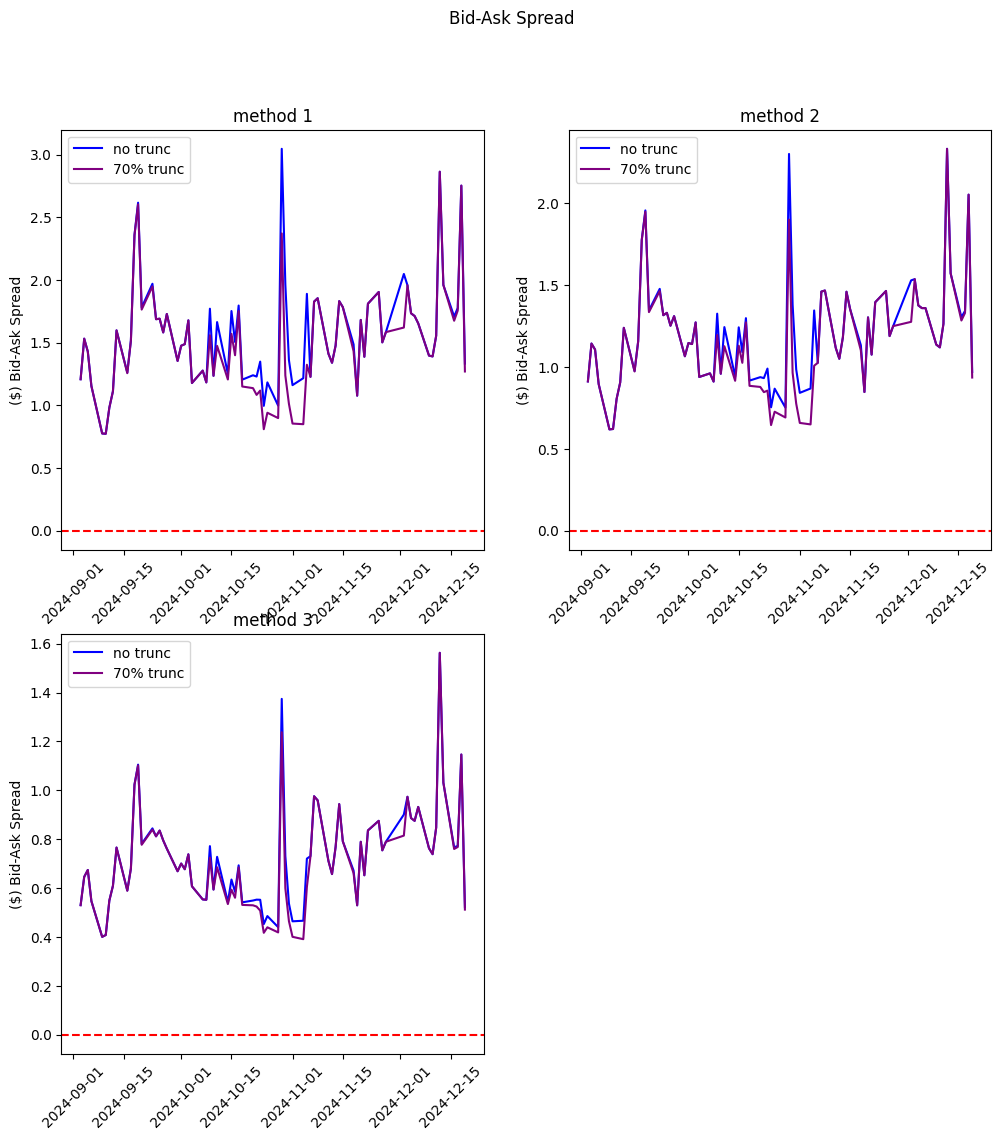

In [9]:
y

#fig, ax = plt.subplots()
fig, ax = plt.subplots( figsize=(12, 12))
#fig= plt.figure(figsize=(10,10))
fig.suptitle('Bid-Ask Spread')

#pd.to_datetime(y4.index)
plt.subplot(2,2,1)
plt.plot(pd.to_datetime(y.index),y.method1_ask-y.method1_bid,label='no trunc',c='blue')
#plt.plot(pd.to_datetime(y2.index),y2.method1_ask-y2.method1_bid,label='10% trunc',c='orange')
#plt.plot(pd.to_datetime(y3.index),y3.method1_ask-y3.method1_bid,label='15% trunc',c='green')
#plt.plot(pd.to_datetime(y4.index),y4.method1_ask-y4.method1_bid,label='20% trunc',c='red')
plt.plot(pd.to_datetime(y5.index),y5.method1_ask-y5.method1_bid,label='70% trunc',c='purple')
plt.axhline(y=0, color='r', linestyle='--') 
plt.title(f'method 1')
#plt.xlabel('$t$')
plt.ylabel('($) Bid-Ask Spread')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.legend()

plt.subplot(2,2,2)
plt.plot(pd.to_datetime(y.index),y.method2_ask-y.method2_bid,label='no trunc',c='blue')
#plt.plot(pd.to_datetime(y2.index),y2.method2_ask-y2.method2_bid,label='10% trunc',c='orange')
#plt.plot(pd.to_datetime(y3.index),y3.method2_ask-y3.method2_bid,label='15% trunc',c='green')
#plt.plot(pd.to_datetime(y4.index),y4.method2_ask-y4.method2_bid,label='20% trunc',c='red')
plt.plot(pd.to_datetime(y5.index),y5.method2_ask-y5.method2_bid,label='70% trunc',c='purple')
plt.axhline(y=0, color='r', linestyle='--') 
plt.title(f'method 2')
#plt.xlabel('$t$')
plt.ylabel('($) Bid-Ask Spread')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.legend()

plt.subplot(2,2,3)
plt.plot(pd.to_datetime(y.index),y.method3_ask-y.method3_bid,label='no trunc',c='blue')
#plt.plot(pd.to_datetime(y2.index),y2.method3_ask-y2.method3_bid,label='10% trunc',c='orange')
#plt.plot(pd.to_datetime(y3.index),y3.method3_ask-y3.method3_bid,label='15% trunc',c='green')
#plt.plot(pd.to_datetime(y4.index),y4.method3_ask-y4.method3_bid,label='20% trunc',c='red')
plt.plot(pd.to_datetime(y5.index),y5.method3_ask-y5.method3_bid,label='70% trunc',c='purple')
plt.axhline(y=0, color='r', linestyle='--') 
plt.title(f'method 3')
#plt.xlabel('$t$')
plt.ylabel('($) Bid-Ask Spread')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.legend()

plt.show()

In [456]:

meth_1_spread=y.method1_ask-y.method1_bid
meth_1_spread_thresh=y5.method1_ask-y5.method1_bid

#np.sign( meth_1_spread-meth_1_spread_thresh ).value_counts()

print(  (meth_1_spread-meth_1_spread_thresh[(meth_1_spread-meth_1_spread_thresh)<0]).dropna()  )

#display( pd.DataFrame(y.loc['2024-09-18']).T )
#display( pd.DataFrame(y5.loc['2024-09-18']).T )


#print(  (meth_1_spread-meth_1_spread_thresh[(meth_1_spread-meth_1_spread_thresh)>0]).dropna()  )

Series([], dtype: float64)


In [13]:
conditions=['None','moneyness_pct<=0.10','moneyness_pct<=0.15','moneyness_pct<=0.20','moneyness_pct<=0.70']
thresholds=['None',-0.10,-0.30,-0.50,-0.70]
#conditions=[None]
bid_ask_final_df=[]
counter=0
#for condition in conditions:
for threshold in thresholds:
    #if condition=='None':
    #    condition=None
    if threshold=='None':
        threshold=None
    SKEW_rep_trunc,term_rep_df,w_rep=index_computation(truncation_condition=None)
    #bid_ask_df=bid_ask_analysis(truncation_condition=condition)
    bid_ask_df=bid_ask_analysis(threshold=threshold)
    
    SKEW_rep_trunc[['CBOE_SKEW','SKEW_method2','SKEW_method3']]=100-10*SKEW_rep_trunc[['CBOE_SKEW','SKEW_method2','SKEW_method3']]
    #SKEW_rep_trunc.rename(columns={'CBOE_SKEW':'method1_spread',
    #                               'SKEW_method2':'method2_spread',
    #                               'SKEW_method3':'method3_spread'},inplace=True)
    bid_ask_df[['method1_bid','method1_ask','method2_bid','method2_ask','method3_bid','method3_ask']]=100-10*bid_ask_df[['method1_bid','method1_ask','method2_bid','method2_ask','method3_bid','method3_ask']]
    bid_ask_df['method1_spread']=bid_ask_df['method1_ask']-bid_ask_df['method1_bid']
    bid_ask_df['method1_spread_pct']=bid_ask_df['method1_spread']/SKEW_rep_trunc['CBOE_SKEW']
    bid_ask_df['method1_spread_pct']*=100
    bid_ask_df['method2_spread']=bid_ask_df['method2_ask']-bid_ask_df['method2_bid']
    bid_ask_df['method2_spread_pct']=bid_ask_df['method2_spread']/SKEW_rep_trunc['SKEW_method2']
    bid_ask_df['method2_spread_pct']*=100
    bid_ask_df['method3_spread']=bid_ask_df['method3_ask']-bid_ask_df['method3_bid']
    bid_ask_df['method3_spread_pct']=bid_ask_df['method3_spread']/SKEW_rep_trunc['SKEW_method3']
    bid_ask_df['method3_spread_pct']*=100
    #bid_ask_df['condition']=str(condition)
    bid_ask_df['threshold']=str(threshold)
    bid_ask_df.reset_index(inplace=True)

    #display(SKEW_rep_trunc)
    #display(bid_ask_df)
    bid_ask_final_df.append(bid_ask_df)
    counter+=1


bid_ask_final_df=pd.concat(bid_ask_final_df,ignore_index=True)
bid_ask_final_df

,CALCULATION_DATE,method1_bid,method1_ask,method2_bid,method2_ask,method3_bid,method3_ask,method1_spread,method1_spread_pct,method2_spread,method2_spread_pct,method3_spread,method3_spread_pct,threshold
0,2024-09-03,169.640524,157.562086,158.337147,149.226013,141.022748,135.724503,-12.078439,-7.382976,-9.111135,-5.941007,-5.298245,-3.828837,None
1,2024-09-04,168.560849,153.242957,156.989733,145.563944,139.480359,133.023471,-15.317893,-9.520339,-11.425789,-7.572316,-6.456889,-4.738879,None
2,2024-09-05,163.861556,149.573337,154.039855,142.983692,138.628742,131.890868,-14.288219,-9.11749,-11.056163,-7.463458,-6.737873,-4.981355,None
3,2024-09-06,154.759080,143.219037,146.550009,137.599080,133.365307,127.900761,-11.540042,-7.745882,-8.950929,-6.318667,-5.464546,-4.18308,None
4,2024-09-09,144.215627,136.462884,138.602290,132.419053,129.000481,124.999234,-7.752742,-5.524474,-6.183237,-4.576042,-4.001247,-3.150507,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,2024-12-13,179.711863,160.111829,168.363399,152.653270,150.661781,140.349016,-19.600034,-11.535775,-15.710129,-9.803622,-10.312764,-7.087495,-0.7
376,2024-12-16,175.163758,158.417732,163.939252,151.106395,146.387771,138.789833,-16.746026,-10.04032,-12.832857,-8.162979,-7.597937,-5.328447,-0.7
377,2024-12-17,181.827315,164.270218,168.533058,155.239252,148.348591,140.669826,-17.557097,-10.145908,-13.293806,-8.228895,-7.678765,-5.313567,-0.7
378,2024-12-18,182.684722,155.157826,166.941498,146.423811,143.691546,132.228785,-27.526896,-16.296118,-20.517687,-13.134877,-11.462761,-8.308713,-0.7


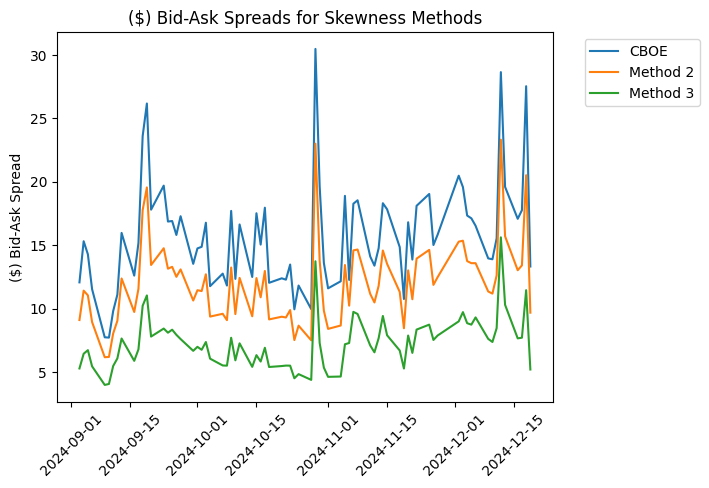

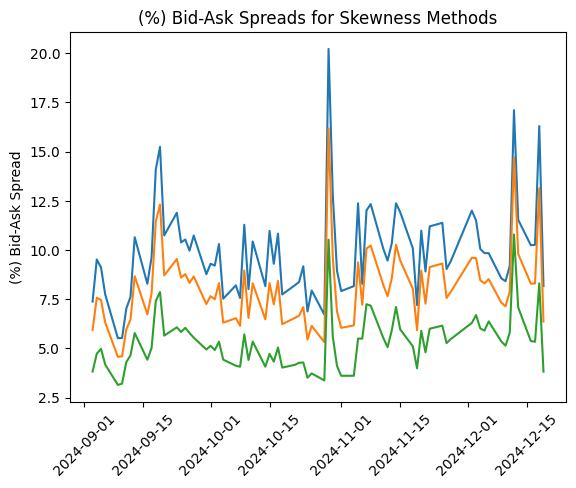

method1_spread    15.686603
method2_spread    12.043551
method3_spread     7.290388
dtype: float64

In [46]:
temp=bid_ask_final_df[bid_ask_final_df.threshold=='None']

plt.plot(pd.to_datetime(temp['CALCULATION_DATE']),-temp['method1_spread'],label='CBOE')
plt.plot(pd.to_datetime(temp['CALCULATION_DATE']),-temp['method2_spread'],label='Method 2')
plt.plot(pd.to_datetime(temp['CALCULATION_DATE']),-temp['method3_spread'],label='Method 3')
plt.title(f'($) Bid-Ask Spreads for Skewness Methods')
plt.ylabel('($) Bid-Ask Spread')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
#plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

plt.plot(pd.to_datetime(temp['CALCULATION_DATE']),-temp['method1_spread_pct'],label='CBOE')
plt.plot(pd.to_datetime(temp['CALCULATION_DATE']),-temp['method2_spread_pct'],label='Method 2')
plt.plot(pd.to_datetime(temp['CALCULATION_DATE']),-temp['method3_spread_pct'],label='Method 3')
plt.title(f'(%) Bid-Ask Spreads for Skewness Methods')
plt.ylabel('(%) Bid-Ask Spread')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
#plt.legend(None)
#plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


-temp[['method1_spread','method2_spread','method3_spread']].mean()

In [459]:
#bid_ask_final_df[bid_ask_final_df.threshold=='None']['method1_spread'].astype(float).sub( bid_ask_final_df[bid_ask_final_df.threshold=='-0.7']['method1_spread'].astype(float) ) 
#bid_ask_final_df[bid_ask_final_df.threshold=='-0.7']['method1_spread'].astype(float)

q1=bid_ask_final_df[bid_ask_final_df.threshold=='None']['method1_spread'].astype(float).reset_index()
q2=bid_ask_final_df[bid_ask_final_df.threshold=='-0.7']['method1_spread'].astype(float).reset_index()
q_sub=q1-q2
q_sub[q_sub>0].dropna(subset=['method1_spread'])

,index,method1_spread


In [303]:
#conditions=['None','moneyness_pct<=0.10','moneyness_pct<=0.15','moneyness_pct<=0.20','moneyness_pct<=0.70']
#bid_ask_final_df.threshold.unique()
#bid_ask_final_df[bid_ask_final_df.threshold=='None']

array(['None', '-0.1', '-0.15', '-0.2', '-0.7'], dtype=object)

/var/folders/nr/239fpjgn5zg829rq2drl_2kw0000gn/T/ipykernel_13743/1388582434.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,int(method[-1]))


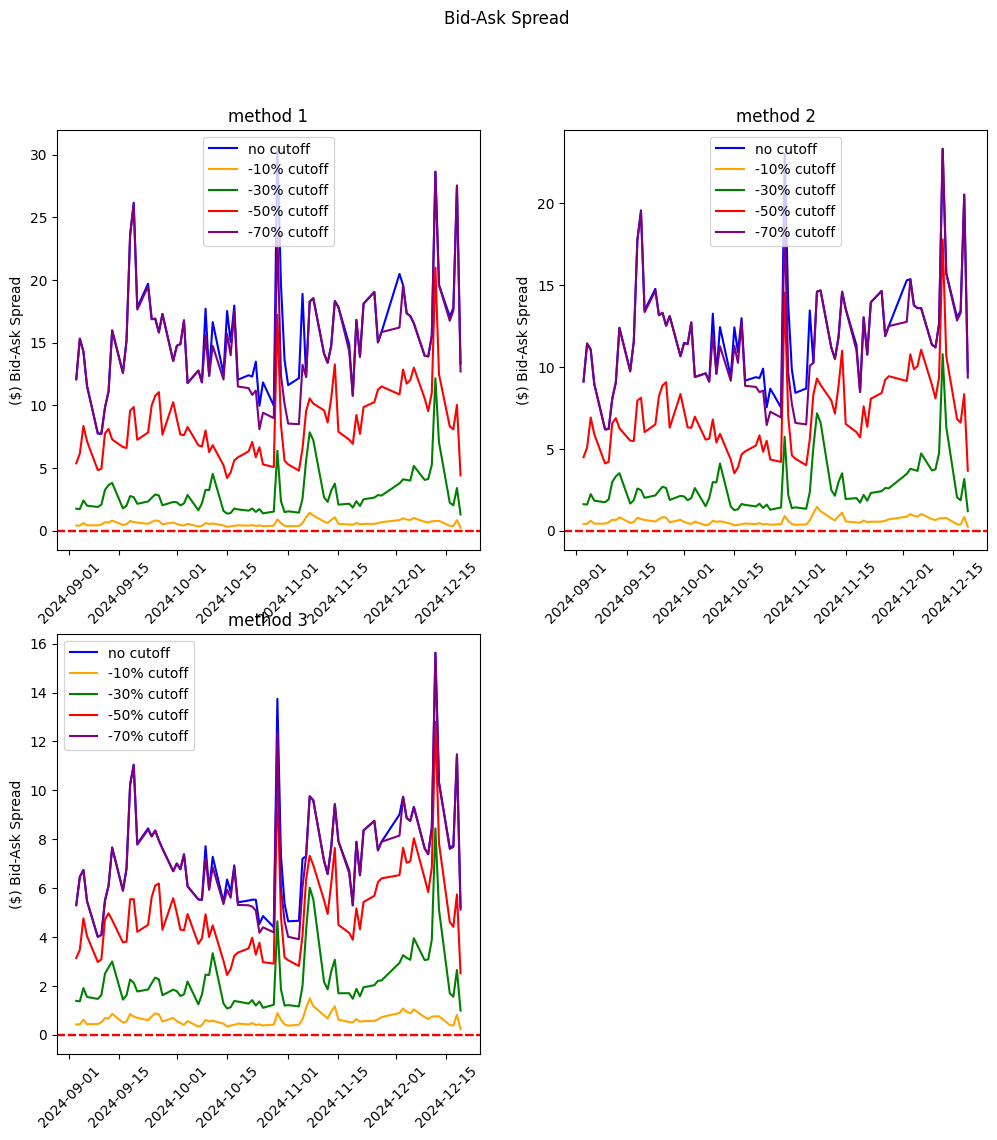

In [534]:
fig, ax = plt.subplots( figsize=(12, 12))
fig.suptitle('Bid-Ask Spread')

methods=['method1','method2','method3']
#conditions=['None','moneyness_pct<=0.10','moneyness_pct<=0.15','moneyness_pct<=0.20','moneyness_pct<=0.70']
thresholds=['None','-0.1','-0.3','-0.5','-0.7']
#thresholds=['None','-0.7']
thresh_mapping={'None':{'label':'no cutoff','color':'blue'},
              '-0.1':{'label':'-10% cutoff','color':'orange'},
              '-0.3':{'label':'-30% cutoff','color':'green'},
              '-0.5':{'label':'-50% cutoff','color':'red'},
              '-0.7':{'label':'-70% cutoff','color':'purple'}}
for method in methods:
    for threshold in thresholds:
        #pd.to_datetime(y4.index)
        plt.subplot(2,2,int(method[-1]))
        #col='_spread_pct'
        #plt.ylabel('(%) Bid-Ask Spread')
        col='_spread'
        plt.ylabel('($) Bid-Ask Spread')

        temp=bid_ask_final_df[bid_ask_final_df.threshold==threshold]
        temp=temp.copy()
        temp['CALCULATION_DATE']=pd.to_datetime(temp['CALCULATION_DATE'])
        #display(bid_ask_final_df[bid_ask_final_df.condition==condition])
        plt.plot(temp.CALCULATION_DATE,
                 -temp[method+col],
                 label=thresh_mapping[threshold]['label'],c=thresh_mapping[threshold]['color'])
        plt.axhline(y=0, color='r', linestyle='--') 
        plt.title(f'method {method[-1]}')
        #plt.ylabel('($) Bid-Ask Spread')
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.xticks(rotation=45)
        plt.legend(  )



plt.show()

In [509]:
temp=bid_ask_final_df.copy()
temp[['method1_spread','method2_spread','method3_spread',
      'method1_spread_pct','method2_spread_pct','method3_spread_pct']]*=-1
temp[['method1_spread','method2_spread','method3_spread','method1_spread_pct','method2_spread_pct','method3_spread_pct']]=temp[['method1_spread','method2_spread','method3_spread','method1_spread_pct','method2_spread_pct','method3_spread_pct']].astype(float)

mean_spreads=pd.DataFrame(temp[['method1_spread','method2_spread','method3_spread']].mean().round(2))
mean_spreads.columns=['BID_ASK_SPREAD($)']
mean_spreads.rename(index={'method1_spread':'Method 1','method2_spread':'Method 2','method3_spread':'Method 3'},inplace=True)

mean_pct_spreads=pd.DataFrame(temp[['method1_spread_pct','method2_spread_pct','method3_spread_pct']].mean().round(2))
mean_pct_spreads.columns=['BID_ASK_SPREAD(%)']
mean_pct_spreads.rename(index={'method1_spread_pct':'Method 1','method2_spread_pct':'Method 2','method3_spread_pct':'Method 3'},inplace=True)

pd.concat([mean_spreads,mean_pct_spreads],axis=1)
#display( temp[['method1_spread_pct','method2_spread_pct','method3_spread_pct']].mean().round(2) )


,BID_ASK_SPREAD($),BID_ASK_SPREAD(%)
Method 1,8.53,5.40
Method 2,6.80,4.56
Method 3,4.46,3.27


In [536]:
methods=['Method 1','Method 2','Method 3']
thresholds=['None','-0.1','-0.3','-0.5','-0.7']

temp=bid_ask_final_df.copy()
temp[['method1_spread','method2_spread','method3_spread',
      'method1_spread_pct','method2_spread_pct','method3_spread_pct']]*=-1
temp[['method1_spread','method2_spread','method3_spread','method1_spread_pct','method2_spread_pct','method3_spread_pct']]=temp[['method1_spread','method2_spread','method3_spread','method1_spread_pct','method2_spread_pct','method3_spread_pct']].astype(float)

mean_spreads=temp.groupby(['threshold'])[['method1_spread','method2_spread','method3_spread']].mean().round(2)
mean_spreads.columns=[method+' BID_ASK($)' for  method in methods]
mean_spreads

mean_pct_spreads=temp.groupby(['threshold'])[['method1_spread_pct','method2_spread_pct','method3_spread_pct']].mean().round(2)
mean_pct_spreads.columns=[method+' BID_ASK(%)' for  method in methods]

agg_spreads_df=pd.concat([mean_spreads,mean_pct_spreads],axis=1)
#agg_spreads_df=agg_spreads_df.reindex(thresholds)
display(agg_spreads_df)
display(mean_pct_spreads)

,Method 1 BID_ASK($),Method 2 BID_ASK($),Method 3 BID_ASK($),Method 1 BID_ASK(%),Method 2 BID_ASK(%),Method 3 BID_ASK(%)
threshold,,,,,,
-0.1,0.60,0.61,0.62,0.38,0.41,0.46
-0.3,2.92,2.68,2.26,1.85,1.80,1.65
-0.5,8.47,7.07,4.97,5.38,4.74,3.64
-0.7,14.96,11.62,7.14,9.46,7.78,5.23
None,15.69,12.04,7.29,9.93,8.07,5.34


,Method 1 BID_ASK(%),Method 2 BID_ASK(%),Method 3 BID_ASK(%)
threshold,,,
-0.1,0.38,0.41,0.46
-0.3,1.85,1.80,1.65
-0.5,5.38,4.74,3.64
-0.7,9.46,7.78,5.23
None,9.93,8.07,5.34


In [1]:
bid_ask_final_df

NameError: name 'bid_ask_final_df' is not defined

In [688]:
#BID-ASk CONTRIBUTION

def bid_ask_contribution(threshold=None):

    def skew_weights_1(slice):
        mins_30_days=30*60*24
        slice1=slice[slice.TERM=='near']
        slice2=slice[slice.TERM=='next']
        w=(slice2.MIN_TO_EXPIRE.unique()[0]-mins_30_days)
        w/=(slice2.MIN_TO_EXPIRE.unique()[0]-slice1.MIN_TO_EXPIRE.unique()[0])
        return [w,1-w]

    def portfolio_constructors(slice):

        F=slice.FORWARD_PRICE.unique()[0]
        K0=slice.K0_SELECTION.unique()[0]
        calls=slice[slice.STRIKE_PRICE>K0]
        puts=slice[slice.STRIKE_PRICE<K0]
        #display(slice)
        #print(5/0)
        pca=pd.DataFrame.from_dict({'STRIKE_PRICE':K0,
                                'CALL_PUT_FLAG':'P/C Avg', #put-call average
                                'midprice':slice[(slice.STRIKE_PRICE==K0)]['midprice'].mean(),
                                'INTEREST_RATE':slice.INTEREST_RATE,

                                'BID_PRICE':slice.BID_PRICE,
                                'ASK_PRICE':slice.ASK_PRICE,
                                'term_weight':slice.term_weight,

                                'YEARS_TO_EXPIRE':slice.YEARS_TO_EXPIRE} ).head(1)
        opt_portfolio=pd.concat([puts,pca,calls],ignore_index=True)[['STRIKE_PRICE','CALL_PUT_FLAG','midprice','INTEREST_RATE','BID_PRICE','ASK_PRICE','term_weight','YEARS_TO_EXPIRE']]
        opt_portfolio['dK']=(opt_portfolio.STRIKE_PRICE.shift(-1)-opt_portfolio.STRIKE_PRICE.shift(1))/2
        opt_portfolio.loc[0,'dK']=opt_portfolio.iloc[1]['STRIKE_PRICE']-opt_portfolio.iloc[0]['STRIKE_PRICE']
        opt_portfolio.loc[opt_portfolio.index[-1],'dK']=opt_portfolio.iloc[-1]['STRIKE_PRICE']-opt_portfolio.iloc[-2]['STRIKE_PRICE']

        #Truncating the portfolio
        #opt_portfolio['moneyness_pct']=F/opt_portfolio['STRIKE_PRICE']-1
        opt_portfolio['moneyness_pct']=opt_portfolio['STRIKE_PRICE']/F-1
        opt_portfolio['z_moneyness']=(opt_portfolio['moneyness_pct']-opt_portfolio['moneyness_pct'].mean()) / opt_portfolio['moneyness_pct'].std() 
        truncation_condition=None
        if truncation_condition:
            opt_portfolio=opt_portfolio.query(truncation_condition)

        if threshold:
            opt_portfolio['BID_PRICE']=np.where(opt_portfolio['moneyness_pct']<=threshold,opt_portfolio['midprice'],opt_portfolio['BID_PRICE'])
            opt_portfolio['ASK_PRICE']=np.where(opt_portfolio['moneyness_pct']<=threshold,opt_portfolio['midprice'],opt_portfolio['ASK_PRICE'])
            
        #print('--------------')
        #display(opt_portfolio)
        #print(5/0)
        r,t=opt_portfolio.INTEREST_RATE.unique()[0],opt_portfolio.YEARS_TO_EXPIRE.unique()[0]
        #display(opt_portfolio)
        #CBOE SKEW
        e1=-(1+np.log(F/K0)-(F/K0))
        e2=2*np.log(K0/F)*(F/K0-1)+(1/2)*np.log(K0/F)**2
        e3=3*np.log(K0/F)**2 * (1/3*np.log(K0/F)-1+F/K0)
        p1_option_weight=-opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
        p2_option_weight=2*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
        p2_option_weight*=1-np.log(opt_portfolio.STRIKE_PRICE/F)
        p3_option_weight=3*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
        p3_option_weight*=2*np.log(opt_portfolio.STRIKE_PRICE/F)-np.log(opt_portfolio.STRIKE_PRICE/F)**2

        P1=( np.exp(r*t)*(opt_portfolio.midprice*p1_option_weight) ).sum()
        P1+=e1
        P2=( np.exp(r*t)*(opt_portfolio.midprice*p2_option_weight) ).sum()
        P2+=e2
        P3=( np.exp(r*t)*(opt_portfolio.midprice*p3_option_weight) ).sum()
        P3+=e3

        S_method1=P3-3*P1*P2+2*P1**3
        sigma=np.sqrt(P2-P1**2)
        S_method1/=sigma**3

        #METHOD2
        S_method2=-6*P1 - 3*P2
        S_method2/=sigma**3

        #METHOD3
        #correction_term=(1/t)*(F/K0-1)**2
        VIX_opt_weight=2*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
        SVIX_opt_weight=2*opt_portfolio.dK/(F**2)
        VIX_square=( np.exp(r*t)*(opt_portfolio.midprice*VIX_opt_weight) ).sum()
        SVIX_square=( np.exp(r*t)*(opt_portfolio.midprice*SVIX_opt_weight) ).sum()
        #VIX_square+=correction_term
        S_method3=3/2*(SVIX_square-VIX_square)
        S_method3/= sigma**3
        #loop through strikes, if weight pos give low bid if weight neg give high bid

        opt_portfolio['meth1_opt_weight']=(p3_option_weight - 3*P1*p2_option_weight + 2*P1**2*p1_option_weight) * np.exp(r*t)/sigma**3
        opt_portfolio['meth1_opt_weight']*=opt_portfolio['term_weight']
        opt_portfolio['meth2_opt_weight']=(-6*p1_option_weight - 3*p2_option_weight) * np.exp(r*t)/sigma**3
        opt_portfolio['meth2_opt_weight']*=opt_portfolio['term_weight']
        opt_portfolio['meth3_opt_weight']=(SVIX_opt_weight-VIX_opt_weight) * 3/2*np.exp(r*t)/sigma**3
        opt_portfolio['meth3_opt_weight']*=opt_portfolio['term_weight']
        
        opt_portfolio['meth1_bid_contribtion']=opt_portfolio.apply(lambda x: x.meth1_opt_weight*x.BID_PRICE if x.meth1_opt_weight >0 else x.meth1_opt_weight*x.ASK_PRICE,axis=1)
        opt_portfolio['meth1_ask_contribtion']=opt_portfolio.apply(lambda x: x.meth1_opt_weight*x.ASK_PRICE if x.meth1_opt_weight >0 else x.meth1_opt_weight*x.BID_PRICE,axis=1)
        opt_portfolio['meth2_bid_contribtion']=opt_portfolio.apply(lambda x: x.meth2_opt_weight*x.BID_PRICE if x.meth2_opt_weight >0 else x.meth2_opt_weight*x.ASK_PRICE,axis=1)
        opt_portfolio['meth2_ask_contribtion']=opt_portfolio.apply(lambda x: x.meth2_opt_weight*x.ASK_PRICE if x.meth2_opt_weight >0 else x.meth2_opt_weight*x.BID_PRICE,axis=1)
        opt_portfolio['meth3_bid_contribtion']=opt_portfolio.apply(lambda x: x.meth3_opt_weight*x.BID_PRICE if x.meth3_opt_weight >0 else x.meth3_opt_weight*x.ASK_PRICE,axis=1)
        opt_portfolio['meth3_ask_contribtion']=opt_portfolio.apply(lambda x: x.meth3_opt_weight*x.ASK_PRICE if x.meth3_opt_weight >0 else x.meth3_opt_weight*x.BID_PRICE,axis=1)
        
        opt_portfolio['interval'] = pd.cut(opt_portfolio['moneyness_pct'], bins=[-np.inf,-0.4,-0.2,np.inf])
        opt_portfolio['meth1_spread_contribution']=opt_portfolio['meth1_ask_contribtion']-opt_portfolio['meth1_bid_contribtion']
        opt_portfolio['meth2_spread_contribution']=opt_portfolio['meth2_ask_contribtion']-opt_portfolio['meth2_bid_contribtion']
        opt_portfolio['meth3_spread_contribution']=opt_portfolio['meth3_ask_contribtion']-opt_portfolio['meth3_bid_contribtion']
        spread_contribution_df=opt_portfolio.groupby(['interval'])[['meth1_spread_contribution','meth2_spread_contribution','meth3_spread_contribution']].sum()
        #spread_contribution_df/=opt_portfolio[['meth1_spread_contribution','meth2_spread_contribution','meth3_spread_contribution']].sum()
        return spread_contribution_df
        #display(spread_contribution_df)
        #display(   opt_portfolio.groupby(['interval'])[['meth1_spread_contribution','meth2_spread_contribution','meth3_spread_contribution']].sum()   )
        #print(5/0)

        #S_method1_bid = opt_portfolio.meth1_bid_contribtion.sum()
        #S_method1_ask = opt_portfolio.meth1_ask_contribtion.sum()
        #S_method2_bid = opt_portfolio.meth2_bid_contribtion.sum()
        #S_method2_ask = opt_portfolio.meth2_ask_contribtion.sum()
        #S_method3_bid = opt_portfolio.meth3_bid_contribtion.sum()
        #S_method3_ask = opt_portfolio.meth3_ask_contribtion.sum()
        #return [S_method1_bid,S_method1_ask,
        #        S_method2_bid,S_method2_ask,
        #        S_method3_bid,S_method3_ask]

    
    term_rep_df=vixmo_data_df.groupby(['CALCULATION_DATE','TERM']).apply(portfolio_constructors)
    #term_rep_df=pd.DataFrame(vixmo_data_df.groupby(['CALCULATION_DATE','TERM']).apply(portfolio_constructors),columns=['Replicates'])
    #display(term_rep_df)
    #print(5/0)

    #display(term_rep_df.loc['2024-09-18'])
    SKEW_rep_2=term_rep_df.copy()

    SKEW_rep_3=SKEW_rep_2.groupby( [SKEW_rep_2.index.get_level_values(0),SKEW_rep_2.index.get_level_values(2) ]).sum()
    #SKEW_rep_3/=SKEW_rep_2.groupby( [SKEW_rep_2.index.get_level_values(0) ]).sum()
    #display(SKEW_rep_3)
    #print(5/0)
    #SKEW_rep_3=100-10*SKEW_rep_3
    SKEW_rep_3*=10
    SKEW_rep_3.rename(columns={'meth1_spread_contribution':'Method 1',
                            'meth2_spread_contribution':'Method 2',
                            'meth3_spread_contribution':'Method 3'},inplace=True)
    return SKEW_rep_3#,term_rep_df,w_rep

spread_contribution_df=bid_ask_contribution(threshold=None)


In [691]:
#spread_contribution_df#*10
display( (spread_contribution_df.groupby([spread_contribution_df.index.get_level_values(1)]).mean()).round(2) )

,Method 1,Method 2,Method 3
interval,,,
"(-inf, -0.4]",10.52,7.52,3.80
"(-0.4, -0.2]",3.78,3.19,2.25
"(-0.2, inf]",1.39,1.34,1.24


,Method 1,Method 2,Method 3
interval,,,
"(-inf, -0.4]",1.05,0.75,0.38
"(-0.4, -0.2]",0.38,0.32,0.22
"(-0.2, inf]",0.14,0.13,0.12


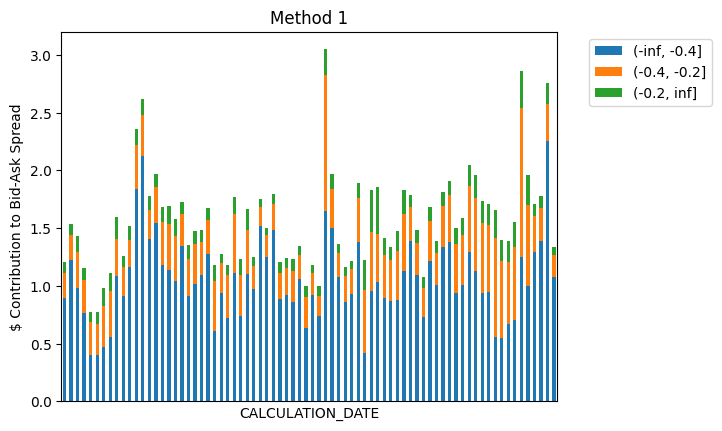

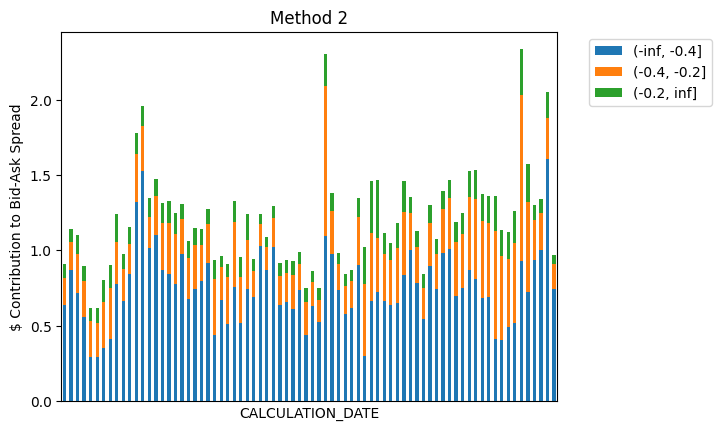

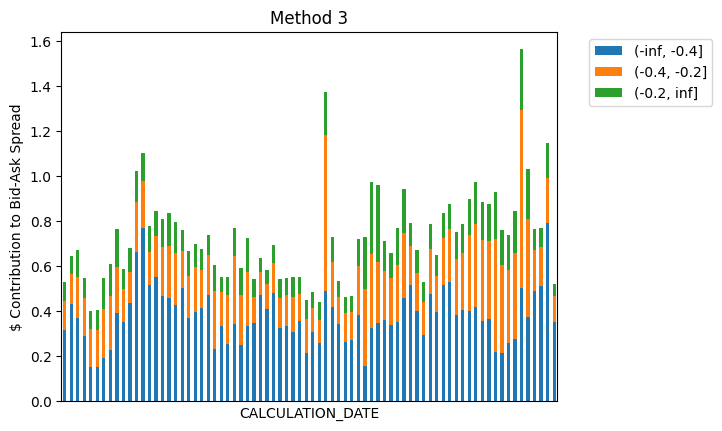

In [656]:
#display( (spread_contribution_df.groupby([spread_contribution_df.index.get_level_values(1)]).mean()*100).round(2) )
display( (spread_contribution_df.groupby([spread_contribution_df.index.get_level_values(1)]).mean()).round(2) )

#fig, ax = plt.subplots( figsize=(12, 12))
#spread_contribution_df.index=pd.to_datetime(spread_contribution_df.index)
#meth1_pivot['CALCULATION_DATE']=pd.to_datetime(meth1_pivot['CALCULATION_DATE'])
methods=['Method 1','Method 2','Method 3']
for method in methods:

    meth1_pivot=spread_contribution_df[[method]].reset_index().pivot(index=['CALCULATION_DATE'],columns=['interval'])
    meth1_pivot.columns=[col[1] for col in meth1_pivot.columns]
    meth1_pivot.index=pd.to_datetime(meth1_pivot.index)
    #display(meth1_pivot)
    meth1_pivot.plot(kind='bar', stacked=True)
    plt.title(method)
    #plt.ylabel('% Contribution to Bid-Ask Spread')
    plt.ylabel('$ Contribution to Bid-Ask Spread')
    plt.xticks([], [])
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()


Brownbag Plot for Bid-Ask Spread

In [54]:
my_day='2024-12-18'
#my_day='2024-10-08'
day_df=vixmo_data_df[(vixmo_data_df.CALCULATION_DATE==my_day) &
                     (vixmo_data_df.TERM=='near') ]
F=day_df.FORWARD_PRICE.unique()[0]

def portfolio_constructors(slice):

    F=slice.FORWARD_PRICE.unique()[0]
    K0=slice.K0_SELECTION.unique()[0]
    calls=slice[slice.STRIKE_PRICE>K0]
    puts=slice[slice.STRIKE_PRICE<K0]
    #display(slice)
    #print(5/0)
    pca=pd.DataFrame.from_dict({'STRIKE_PRICE':K0,
                            'CALL_PUT_FLAG':'P/C Avg', #put-call average
                            'midprice':slice[(slice.STRIKE_PRICE==K0)]['midprice'].mean(),
                            'INTEREST_RATE':slice.INTEREST_RATE,

                            'BID_PRICE':slice.BID_PRICE,
                            'ASK_PRICE':slice.ASK_PRICE,
                            'term_weight':slice.term_weight,

                            'YEARS_TO_EXPIRE':slice.YEARS_TO_EXPIRE} ).head(1)
    opt_portfolio=pd.concat([puts,pca,calls],ignore_index=True)[['STRIKE_PRICE','CALL_PUT_FLAG','midprice','INTEREST_RATE','BID_PRICE','ASK_PRICE','term_weight','YEARS_TO_EXPIRE']]
    opt_portfolio['dK']=(opt_portfolio.STRIKE_PRICE.shift(-1)-opt_portfolio.STRIKE_PRICE.shift(1))/2
    opt_portfolio.loc[0,'dK']=opt_portfolio.iloc[1]['STRIKE_PRICE']-opt_portfolio.iloc[0]['STRIKE_PRICE']
    opt_portfolio.loc[opt_portfolio.index[-1],'dK']=opt_portfolio.iloc[-1]['STRIKE_PRICE']-opt_portfolio.iloc[-2]['STRIKE_PRICE']

    #Truncating the portfolio
    #opt_portfolio['moneyness_pct']=F/opt_portfolio['STRIKE_PRICE']-1
    opt_portfolio['moneyness_pct']=opt_portfolio['STRIKE_PRICE']/F-1
    opt_portfolio['z_moneyness']=(opt_portfolio['moneyness_pct']-opt_portfolio['moneyness_pct'].mean()) / opt_portfolio['moneyness_pct'].std() 
    truncation_condition=None
    if truncation_condition:
        opt_portfolio=opt_portfolio.query(truncation_condition)

    if threshold:
        opt_portfolio['BID_PRICE']=np.where(opt_portfolio['moneyness_pct']<=threshold,opt_portfolio['midprice'],opt_portfolio['BID_PRICE'])
        opt_portfolio['ASK_PRICE']=np.where(opt_portfolio['moneyness_pct']<=threshold,opt_portfolio['midprice'],opt_portfolio['ASK_PRICE'])
        
    #print('--------------')
    #display(opt_portfolio)
    #print(5/0)
    r,t=opt_portfolio.INTEREST_RATE.unique()[0],opt_portfolio.YEARS_TO_EXPIRE.unique()[0]
    #display(opt_portfolio)
    #CBOE SKEW
    e1=-(1+np.log(F/K0)-(F/K0))
    e2=2*np.log(K0/F)*(F/K0-1)+(1/2)*np.log(K0/F)**2
    e3=3*np.log(K0/F)**2 * (1/3*np.log(K0/F)-1+F/K0)
    p1_option_weight=-opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
    p2_option_weight=2*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
    p2_option_weight*=1-np.log(opt_portfolio.STRIKE_PRICE/F)
    p3_option_weight=3*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
    p3_option_weight*=2*np.log(opt_portfolio.STRIKE_PRICE/F)-np.log(opt_portfolio.STRIKE_PRICE/F)**2

    P1=( np.exp(r*t)*(opt_portfolio.midprice*p1_option_weight) ).sum()
    P1+=e1
    P2=( np.exp(r*t)*(opt_portfolio.midprice*p2_option_weight) ).sum()
    P2+=e2
    P3=( np.exp(r*t)*(opt_portfolio.midprice*p3_option_weight) ).sum()
    P3+=e3

    S_method1=P3-3*P1*P2+2*P1**3
    sigma=np.sqrt(P2-P1**2)
    S_method1/=sigma**3

    #METHOD2
    S_method2=-6*P1 - 3*P2
    S_method2/=sigma**3

    #METHOD3
    #correction_term=(1/t)*(F/K0-1)**2
    VIX_opt_weight=2*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
    SVIX_opt_weight=2*opt_portfolio.dK/(F**2)
    VIX_square=( np.exp(r*t)*(opt_portfolio.midprice*VIX_opt_weight) ).sum()
    SVIX_square=( np.exp(r*t)*(opt_portfolio.midprice*SVIX_opt_weight) ).sum()
    #VIX_square+=correction_term
    S_method3=3/2*(SVIX_square-VIX_square)
    S_method3/= sigma**3
    #loop through strikes, if weight pos give low bid if weight neg give high bid

    opt_portfolio['meth1_opt_weight']=(p3_option_weight - 3*P1*p2_option_weight + 2*P1**2*p1_option_weight) * np.exp(r*t)/sigma**3
    opt_portfolio['meth1_opt_weight']*=opt_portfolio['term_weight']
    opt_portfolio['meth2_opt_weight']=(-6*p1_option_weight - 3*p2_option_weight) * np.exp(r*t)/sigma**3
    opt_portfolio['meth2_opt_weight']*=opt_portfolio['term_weight']
    opt_portfolio['meth3_opt_weight']=(SVIX_opt_weight-VIX_opt_weight) * 3/2*np.exp(r*t)/sigma**3
    opt_portfolio['meth3_opt_weight']*=opt_portfolio['term_weight']
    
    opt_portfolio['meth1_bid_contribtion']=opt_portfolio.apply(lambda x: x.meth1_opt_weight*x.BID_PRICE if x.meth1_opt_weight >0 else x.meth1_opt_weight*x.ASK_PRICE,axis=1)
    opt_portfolio['meth1_ask_contribtion']=opt_portfolio.apply(lambda x: x.meth1_opt_weight*x.ASK_PRICE if x.meth1_opt_weight >0 else x.meth1_opt_weight*x.BID_PRICE,axis=1)
    opt_portfolio['meth2_bid_contribtion']=opt_portfolio.apply(lambda x: x.meth2_opt_weight*x.BID_PRICE if x.meth2_opt_weight >0 else x.meth2_opt_weight*x.ASK_PRICE,axis=1)
    opt_portfolio['meth2_ask_contribtion']=opt_portfolio.apply(lambda x: x.meth2_opt_weight*x.ASK_PRICE if x.meth2_opt_weight >0 else x.meth2_opt_weight*x.BID_PRICE,axis=1)
    opt_portfolio['meth3_bid_contribtion']=opt_portfolio.apply(lambda x: x.meth3_opt_weight*x.BID_PRICE if x.meth3_opt_weight >0 else x.meth3_opt_weight*x.ASK_PRICE,axis=1)
    opt_portfolio['meth3_ask_contribtion']=opt_portfolio.apply(lambda x: x.meth3_opt_weight*x.ASK_PRICE if x.meth3_opt_weight >0 else x.meth3_opt_weight*x.BID_PRICE,axis=1)
    return opt_portfolio
    #S_method1_bid = opt_portfolio.meth1_bid_contribtion.sum()
    #S_method1_ask = opt_portfolio.meth1_ask_contribtion.sum()
    #S_method2_bid = opt_portfolio.meth2_bid_contribtion.sum()
    #S_method2_ask = opt_portfolio.meth2_ask_contribtion.sum()
    #S_method3_bid = opt_portfolio.meth3_bid_contribtion.sum()
    #S_method3_ask = opt_portfolio.meth3_ask_contribtion.sum()
    #return [S_method1_bid,S_method1_ask,
    #        S_method2_bid,S_method2_ask,
    #        S_method3_bid,S_method3_ask]


opt_port=portfolio_constructors(day_df)

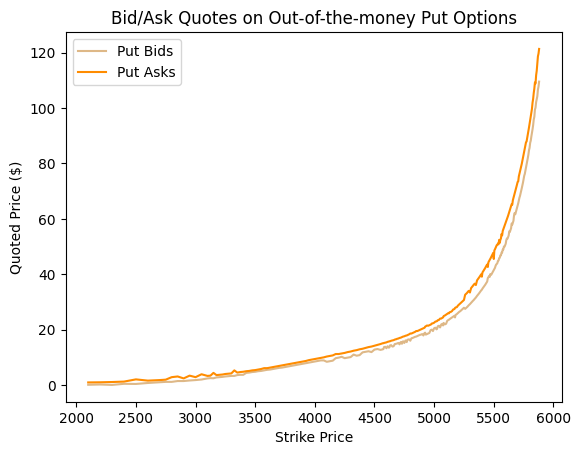

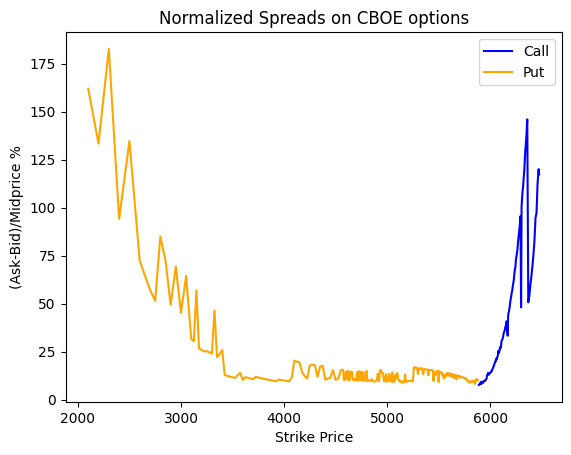

In [99]:
call_port=opt_port[opt_port.CALL_PUT_FLAG=='C']
#plt.title('Bid/Ask Quotes on Out-of-the-money Call Options')
#plt.plot(call_port.STRIKE_PRICE,call_port.BID_PRICE,label='Call Bids',c='cyan')
#plt.plot(call_port.STRIKE_PRICE,call_port.ASK_PRICE,label='Call Asks',c='Blue')
put_port=opt_port[opt_port.CALL_PUT_FLAG=='P']
plt.title('Bid/Ask Quotes on Out-of-the-money Put Options')
plt.plot(put_port.STRIKE_PRICE,put_port.BID_PRICE,label='Put Bids',c='burlywood')
plt.plot(put_port.STRIKE_PRICE,put_port.ASK_PRICE,label='Put Asks',c='darkorange')
plt.ylabel('Quoted Price ($)')
plt.xlabel('Strike Price')
plt.legend()
plt.show()

plt.plot(call_port.STRIKE_PRICE, 100*(call_port.ASK_PRICE-call_port.BID_PRICE)/call_port.midprice,label='Call',color='blue')
plt.plot(put_port.STRIKE_PRICE, 100*(put_port.ASK_PRICE-put_port.BID_PRICE)/put_port.midprice,label='Put',color='orange')
plt.title('Normalized Spreads on CBOE options')
plt.ylabel('(Ask-Bid)/Midprice %')
plt.xlabel('Strike Price')
plt.legend()
plt.show()

In [ ]:
display( put_port[put_port.STRIKE_PRICE<=2100] )

(0.95-0.1)/0.525
print(0.95-0.1)
print(0.525)


,STRIKE_PRICE,CALL_PUT_FLAG,midprice,INTEREST_RATE,BID_PRICE,ASK_PRICE,term_weight,YEARS_TO_EXPIRE,dK,moneyness_pct,z_moneyness,meth1_opt_weight,meth2_opt_weight,meth3_opt_weight,meth1_bid_contribtion,meth1_ask_contribtion,meth2_bid_contribtion,meth2_ask_contribtion,meth3_bid_contribtion,meth3_ask_contribtion
0,2100.0,P,0.525,0.044107,0.1,0.95,0.991964,0.081421,100.0,-0.643288,-3.251675,-0.327954,-0.217293,-0.091986,-0.311556,-0.032795,-0.206428,-0.021729,-0.087387,-0.009199


0.85
0.525


# Composite Table

In [708]:
comp_table_pt1=pd.DataFrame( SKEW_rep_4[['CBOE_SKEW','SKEW_method2','SKEW_method3']].mean(),columns=['Mean Skew Level'] )
comp_table_pt1.rename(index={'CBOE_SKEW':'Method 1','SKEW_method2':'Method 2','SKEW_method3':'Method 3'},inplace=True)
comp_table_pt1=comp_table_pt1.astype(float)
display(comp_table_pt1)

comp_table_pt2=pd.DataFrame( SKEW_rep_2.corr().iloc[:3,0]*100 )
comp_table_pt2.rename(index={'CBOE_SKEW':'Method 1','SKEW_method2':'Method 2','SKEW_method3':'Method 3'},columns={'CBOE_SKEW':'CBOE SKEW Correlation'},inplace=True)
display(comp_table_pt2)

comp_table_pt3=pd.DataFrame( -bid_ask_final_df[bid_ask_final_df.threshold=='None'][['method1_spread','method2_spread','method3_spread']].mean() , columns=['Mean Bid-Ask Spread ($)'] )
comp_table_pt3.rename(index={'method1_spread':'Method 1','method2_spread':'Method 2','method3_spread':'Method 3'},inplace=True)
display( comp_table_pt3 )

comp_table_pt4=(spread_contribution_df.groupby([spread_contribution_df.index.get_level_values(1)]).mean()).round(2).T
comp_table_pt4.columns=[str(col) for col in comp_table_pt4.columns]
comp_table_pt4.rename(columns={'(-inf, -0.4]':'K < 0.6F',	
                               '(-0.4, -0.2]':	'0.6F < K < 0.8F',
                               '(-0.2, inf]':  '0.8F < K'},inplace=True)
#comp_table_pt4

comp_table_final=pd.concat([comp_table_pt1,comp_table_pt2,comp_table_pt3,comp_table_pt4],axis=1)
comp_table_final.iloc[:,1]=comp_table_final.iloc[:,1].round(1)
comp_table_final[['Mean Skew Level','Mean Bid-Ask Spread ($)','K < 0.6F','0.6F < K < 0.8F',	'0.8F < K']]=comp_table_final[['Mean Skew Level','Mean Bid-Ask Spread ($)','K < 0.6F','0.6F < K < 0.8F',	'0.8F < K']].round(2)
comp_table_final


,Mean Skew Level
Method 1,157.041312
Method 2,148.470092
Method 3,135.789535


,CBOE SKEW Correlation
Method 1,100.000000
Method 2,99.171411
Method 3,93.388709


,Mean Bid-Ask Spread ($)
Method 1,15.686603
Method 2,12.043551
Method 3,7.290388


,Mean Skew Level,CBOE SKEW Correlation,Mean Bid-Ask Spread ($),K < 0.6F,0.6F < K < 0.8F,0.8F < K
Method 1,157.04,100.0,15.69,10.52,3.78,1.39
Method 2,148.47,99.2,12.04,7.52,3.19,1.34
Method 3,135.79,93.4,7.29,3.80,2.25,1.24


In [683]:
print(  -bid_ask_final_df[bid_ask_final_df.threshold=='None'][['method1_spread','method2_spread','method3_spread']].mean()  )
print(  -bid_ask_final_df[['method1_spread','method2_spread','method3_spread']].mean()  )

method1_spread    15.686603
method2_spread    12.043551
method3_spread     7.290388
dtype: float64
method1_spread    8.529992
method2_spread    6.804563
method3_spread    4.458008
dtype: float64


# Moneyness Analysis

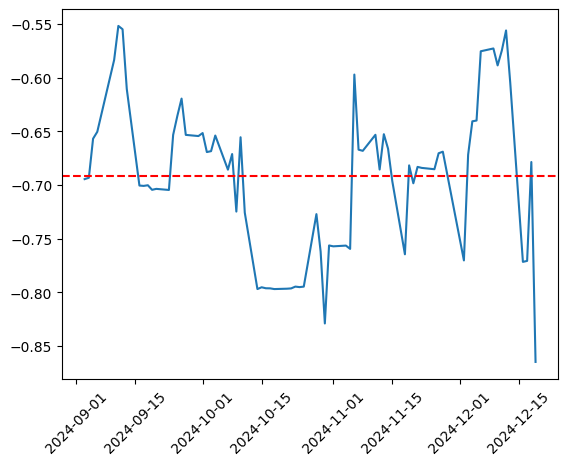

In [280]:
oom_df=vixmo_data_df.groupby(['CALCULATION_DATE','TERM']).apply( lambda x: x.STRIKE_PRICE.min() / x.FORWARD_PRICE - 1 ).groupby(['CALCULATION_DATE']).min()
#oom_df['CALCULATION_DATE']=pd.to_datetime(oom_df['CALCULATION_DATE'])
oom_df.index=pd.to_datetime(oom_df.index)
plt.plot(oom_df)
plt.axhline(y=oom_df.mean(), color='r', linestyle='--') 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()

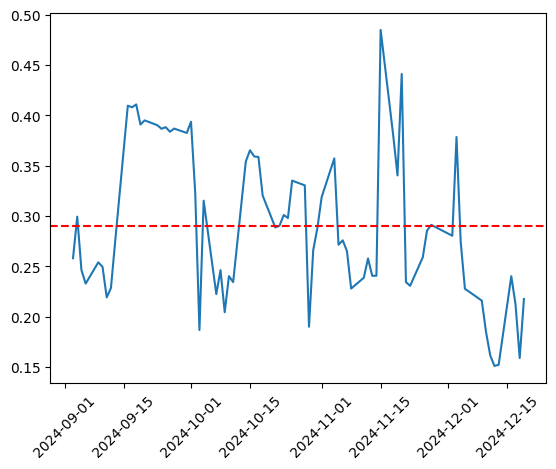

In [700]:
oom_df=vixmo_data_df.groupby(['CALCULATION_DATE','TERM']).apply( lambda x: x.STRIKE_PRICE.max() / x.FORWARD_PRICE - 1 ).groupby(['CALCULATION_DATE']).max()
#oom_df['CALCULATION_DATE']=pd.to_datetime(oom_df['CALCULATION_DATE'])
oom_df.index=pd.to_datetime(oom_df.index)
plt.plot(oom_df)
plt.axhline(y=oom_df.mean(), color='r', linestyle='--') 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()

# Reconciling sigma

5725.801103639765
0.049373239973268195
0.044084909250467104
0.039148147898833335
0.03455190935771903
0.030286539545359942
0.026344363786006852
0.022712538047989582
0.019384624920027144
0.01635070374827672
0.01360229228178893
0.011131207849911614
0.008929036414285555
0.0069884672715298255
0.005301192089807755
0.0038606805017366006
0.0026589130510537595
0.0016895514807357252
0.000945360834196436
0.00042001689087305686
0.00010699574640468878
0.0
9.315046132484845e-05
0.00038018798153281237
0.0008558180695755488
0.0015138752137224866
0.0023494597396499723
0.0033567200904593875
0.004530829827256429
0.0058669414581199
0.007358965881447406
0.009003249271356371
0.01079482302751059
0.012728591486445267
0.014802129195699728
0.017006850629528728
0.01934367602253254
0.021807682946998263
0.02438354093037559
0.027074853631129516
0.029763270567787027


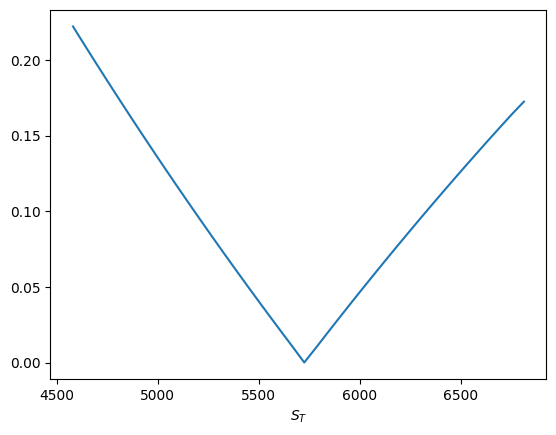

[0.22220090002803364,
 0.2099640665696564,
 0.19785890907116954,
 0.18588143898119314,
 0.1740302834145826,
 0.1623094691815818,
 0.15070679496290001,
 0.13922867851138696,
 0.12786987036935918,
 0.11662886555989872,
 0.10550453947537809,
 0.09449357869339882,
 0.08359705300744653,
 0.0728092857388929,
 0.06213437455818317,
 0.051564649238153064,
 0.04110415405692867,
 0.03074672070638487,
 0.020494313622882246,
 0.010343874825455342,
 0.0,
 0.009651448664570954,
 0.019498409718046558,
 0.029254368384491723,
 0.038908549365434926,
 0.04847122589382254,
 0.057937208169356824,
 0.06731143905203951,
 0.0765959624139543,
 0.08578441514312146,
 0.09488545342335869,
 0.10389813774803949,
 0.11282105958749575,
 0.1216640012316697,
 0.13041031642293,
 0.1390815445072873,
 0.14767424605190393,
 0.15615230043254436,
 0.1645443819494592,
 0.17252034827169527]

In [182]:
#ST=100
my_day='2024-11-04'
day_df=vixmo_data_df[(vixmo_data_df.CALCULATION_DATE==my_day) &
                    (vixmo_data_df.TERM=='near') ]
F=day_df.FORWARD_PRICE.unique()[0]

def calcultae_sigma(day_df,ST):

    F=day_df.FORWARD_PRICE.unique()[0]
    K0=day_df.K0_SELECTION.unique()[0]
    calls=day_df[day_df.STRIKE_PRICE>K0]
    puts=day_df[day_df.STRIKE_PRICE<K0]
    pca=pd.DataFrame.from_dict({'STRIKE_PRICE':K0,
                            'CALL_PUT_FLAG':'P/C Avg', #put-call average
                            'midprice':day_df[(day_df.STRIKE_PRICE==K0)]['midprice'].mean(),
                            'INTEREST_RATE':day_df.INTEREST_RATE,
                            'YEARS_TO_EXPIRE':day_df.YEARS_TO_EXPIRE} ).head(1)
    opt_portfolio=pd.concat([puts,pca,calls],ignore_index=True)[['STRIKE_PRICE','CALL_PUT_FLAG','midprice','INTEREST_RATE','YEARS_TO_EXPIRE']]
    #opt_portfolio=pd.concat([puts,calls],ignore_index=True)[['STRIKE_PRICE','CALL_PUT_FLAG','midprice','INTEREST_RATE','YEARS_TO_EXPIRE']]
    opt_portfolio['dK']=(opt_portfolio.STRIKE_PRICE.shift(-1)-opt_portfolio.STRIKE_PRICE.shift(1))/2
    opt_portfolio.loc[0,'dK']=opt_portfolio.iloc[1]['STRIKE_PRICE']-opt_portfolio.iloc[0]['STRIKE_PRICE']
    opt_portfolio.loc[opt_portfolio.index[-1],'dK']=opt_portfolio.iloc[-1]['STRIKE_PRICE']-opt_portfolio.iloc[-2]['STRIKE_PRICE']

    opt_portfolio['option_payoff']=np.where(opt_portfolio['CALL_PUT_FLAG']=='C', 
                                                np.where(opt_portfolio.STRIKE_PRICE<=ST,ST-opt_portfolio.STRIKE_PRICE,0), 
                                                np.where(opt_portfolio.STRIKE_PRICE>=ST,opt_portfolio.STRIKE_PRICE-ST,0) )

    r,t=opt_portfolio.INTEREST_RATE.unique()[0],opt_portfolio.YEARS_TO_EXPIRE.unique()[0]
    t=0
    e1=-(1+np.log(F/K0)-(F/K0))
    e2=2*np.log(K0/F)*(F/K0-1)+(1/2)*np.log(K0/F)**2
    e3=3*np.log(K0/F)**2 * (1/3*np.log(K0/F)-1+F/K0)
    p1_option_weight=-opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
    p2_option_weight=2*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
    p2_option_weight*=1-np.log(opt_portfolio.STRIKE_PRICE/F)
    p3_option_weight=3*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
    p3_option_weight*=2*np.log(opt_portfolio.STRIKE_PRICE/F)-np.log(opt_portfolio.STRIKE_PRICE/F)**2

    P1=( np.exp(r*t)*(opt_portfolio.option_payoff*p1_option_weight) ).sum()
    #P1+=e1
    P2=( np.exp(r*t)*(opt_portfolio.option_payoff*p2_option_weight) ).sum()
    #P2+=e2
    sigma=np.sqrt(P2-P1**2)#**0.5
    print(P2-P1**2)
    #if P2-P1**2<0:
    #    sigma=0
    #sigma=(P2-P1**2)
    #P3=( np.exp(r*t)*(opt_portfolio.midprice*p3_option_weight) ).sum()
    #P3+=e3
    #S=P3-3*P1*P2+2*P1**3
    #S/=(P2-P1**2)**(3/2)
    #if ST==F:
    #    print(P2-P1**2)
    return sigma


print(F)
spotS_T=np.array([F*(1+0.01*i) for i in range(-20,20)])
sigmas=[calcultae_sigma(day_df,s) for s in spotS_T]
plt.xlabel('$S_T$')
plt.plot(spotS_T,sigmas)
plt.show()

sigmas


In [566]:


def quality_check(slice):
    truncation_condition=None
    F=slice.FORWARD_PRICE.unique()[0]
    K0=slice.K0_SELECTION.unique()[0]
    calls=slice[slice.STRIKE_PRICE>K0]
    puts=slice[slice.STRIKE_PRICE<K0]
    pca=pd.DataFrame.from_dict({'STRIKE_PRICE':K0,
                            'CALL_PUT_FLAG':'P/C Avg', #put-call average
                            'midprice':slice[(slice.STRIKE_PRICE==K0)]['midprice'].mean(),
                            'INTEREST_RATE':slice.INTEREST_RATE,
                            'YEARS_TO_EXPIRE':slice.YEARS_TO_EXPIRE} ).head(1)
    opt_portfolio=pd.concat([puts,pca,calls],ignore_index=True)[['STRIKE_PRICE','CALL_PUT_FLAG','midprice','INTEREST_RATE','YEARS_TO_EXPIRE']]
    #opt_portfolio=pd.concat([puts,calls],ignore_index=True)[['STRIKE_PRICE','CALL_PUT_FLAG','midprice','INTEREST_RATE','YEARS_TO_EXPIRE']]
    opt_portfolio['dK']=(opt_portfolio.STRIKE_PRICE.shift(-1)-opt_portfolio.STRIKE_PRICE.shift(1))/2
    opt_portfolio.loc[0,'dK']=opt_portfolio.iloc[1]['STRIKE_PRICE']-opt_portfolio.iloc[0]['STRIKE_PRICE']
    opt_portfolio.loc[opt_portfolio.index[-1],'dK']=opt_portfolio.iloc[-1]['STRIKE_PRICE']-opt_portfolio.iloc[-2]['STRIKE_PRICE']

    #Truncating the portfolio
    opt_portfolio['moneyness_pct']=F/opt_portfolio['STRIKE_PRICE']-1
    opt_portfolio['z_moneyness']=(opt_portfolio['moneyness_pct']-opt_portfolio['moneyness_pct'].mean()) / opt_portfolio['moneyness_pct'].std() 

    if truncation_condition:
        opt_portfolio=opt_portfolio.query(truncation_condition)

    r,t=opt_portfolio.INTEREST_RATE.unique()[0],opt_portfolio.YEARS_TO_EXPIRE.unique()[0]
    #CBOE SKEW
    e1=-(1+np.log(F/K0)-(F/K0))
    e2=2*np.log(K0/F)*(F/K0-1)+(1/2)*np.log(K0/F)**2
    e3=3*np.log(K0/F)**2 * (1/3*np.log(K0/F)-1+F/K0)
    p1_option_weight=-opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
    p2_option_weight=2*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
    p2_option_weight*=1-np.log(opt_portfolio.STRIKE_PRICE/F)
    p3_option_weight=3*opt_portfolio.dK/(opt_portfolio.STRIKE_PRICE**2)
    p3_option_weight*=2*np.log(opt_portfolio.STRIKE_PRICE/F)-np.log(opt_portfolio.STRIKE_PRICE/F)**2

    P1=( np.exp(r*t)*(opt_portfolio.midprice*p1_option_weight) ).sum()
    P1+=e1
    P2=( np.exp(r*t)*(opt_portfolio.midprice*p2_option_weight) ).sum()
    P2+=e2
    P3=( np.exp(r*t)*(opt_portfolio.midprice*p3_option_weight) ).sum()
    P3+=e3
    S=P3-3*P1*P2+2*P1**3
    sigma=np.sqrt(P2-P1**2)
    S/=sigma**3

    return [P1,P2,P3,S]

test_df=pd.DataFrame(vixmo_data_df.groupby(['CALCULATION_DATE','TERM']).apply(quality_check),columns=['Replicates'])
test_df['P1_UMD']=test_df['Replicates'].apply(lambda x:x[0])
test_df['P2_UMD']=test_df['Replicates'].apply(lambda x:x[1])
test_df['P3_UMD']=test_df['Replicates'].apply(lambda x:x[2])
test_df['S_UMD']=test_df['Replicates'].apply(lambda x:x[3])
test_df.drop(['Replicates'],axis=1,inplace=True)
#display(test_df)

cboe_df=pd.DataFrame(vixmo_data_df.groupby(['CALCULATION_DATE','TERM'])[['P1','P2','P3','S']].mean())
cboe_df.columns=[i+'_CBOE' for i in cboe_df.columns]
cboe_df

merged_df=test_df.join(cboe_df,how='inner')
merged_df['P1_error']=abs(merged_df['P1_UMD']-merged_df['P1_CBOE'])
merged_df['P2_error']=abs(merged_df['P2_UMD']-merged_df['P2_CBOE'])
merged_df['P3_error']=abs(merged_df['P3_UMD']-merged_df['P3_CBOE'])
merged_df['S_error']=abs(merged_df['S_UMD']-merged_df['S_CBOE'])
merged_df[['P1_error','P2_error','P3_error','S_error']].describe()

,P1_error,P2_error,P3_error,S_error
count,1.520000e+02,1.520000e+02,1.520000e+02,1.520000e+02
mean,4.993348e-17,4.826590e-17,4.776499e-17,1.352719e-15
std,2.770838e-17,2.947796e-17,3.033395e-17,2.019507e-15
min,4.336809e-19,2.168404e-19,0.000000e+00,0.000000e+00
25%,2.705084e-17,2.059984e-17,2.141299e-17,0.000000e+00
50%,5.213657e-17,4.683753e-17,4.912791e-17,8.881784e-16
75%,7.299391e-17,7.155734e-17,7.239760e-17,1.776357e-15
max,9.931292e-17,9.887924e-17,9.887924e-17,1.865175e-14


# Custom Data

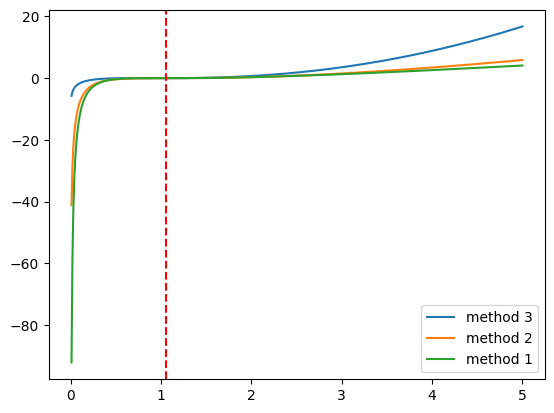

In [32]:
from scipy.stats import norm
r=0.05
sigma,T,S0=0.3,1,1
t=0
num_strikes=1_000
dK=0.01
K=np.around( np.arange(0.01,num_strikes*dK+dK,dK) , 6 )
F=S0*np.exp(r*T)
#print(K)

def payoff_func(F,K,ST):
    return np.where(F>=K,np.maximum(K-ST,0), np.maximum(ST-K,0)  )  

def black_scholes_price(S,K,T,r,sigma,option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return price

ST=np.arange(0.01,5+dK,dK)
#ST=np.arange(0.5,1.5+dK,dK)

final_dict={}
for k in K:
    final_dict[k]={'r':r,'t':t}
    #final_dict[k]['payoff']=[payoff_func(F,k,s) for s in ST]
    final_dict[k]['payoff']=payoff_func(F,k,ST)
    if k==F:
        final_dict[k]['type']='P/C Avg'
    elif k>F:
        final_dict[k]['type']='Call'
        final_dict[k]['price']=black_scholes_price(S0,k,T,r,sigma,option_type='call')
    elif k<F:
        final_dict[k]['type']='Put'
        final_dict[k]['price']=black_scholes_price(S0,k,T,r,sigma,option_type='put')
    

final_df=pd.DataFrame.from_dict(final_dict,orient='index')
#final_df



port_value = final_df.payoff.values.sum(axis=0)
#plt.plot( ST, port_value )

vix_sqaure = (final_df.payoff.values * 2*dK/K**2).sum(axis=0)
svix_sqaure = (final_df.payoff.values * 2*dK/F**2).sum(axis=0)
#plt.plot( ST, vix_sqaure,label=r'$VIX^2$' )
#plt.plot( ST, svix_sqaure,label=r'$SVIX^2$' )

p1_weight=-dK/K**2
p2_weight=2*dK/K**2 * (1-np.log(K/F))
p3_weight=3*dK/K**2 * (2*np.log(K/F)-np.log(K/F)**2)
P1_payoff = (final_df.payoff.values * p1_weight).sum(axis=0)
P2_payoff = (final_df.payoff.values * p2_weight).sum(axis=0)
P3_payoff = (final_df.payoff.values * p3_weight).sum(axis=0)
P1=np.exp(r*T)*(final_df.price * p1_weight).sum(axis=0)
#method 3
#plt.title('Method 3 Payoff')
#plt.plot( ST, 3/2 * svix_sqaure-vix_sqaure,label=r'$SVIX^2-VIX^2$' )
#plt.plot( ST, 3/2 * (ST/F-1)**2 + 2*np.log(ST/F) - 2*ST/F + 2,label=r'$\frac{3}{2}(S_T/F-1)^2 + 2\log(S_T/F)-2S_T/F+2)$' )
#method 2
#plt.title('Method 2 Payoff')
#plt.plot( ST, -6*P1_payoff - 3*P2_payoff,label='$-6P_1-3P_2$' )
#plt.plot( ST, 6*(ST/F-1) - 6*np.log(ST/F) - 3*np.log(ST/F)**2,label=r'$6(S_T/F-1)-6\log(S_T/F)-3\log^2(S_T/F)$' )
#method 1
#plt.title('Method 1 Payoff')
#plt.plot( ST, P3_payoff - 3*P1*P2_payoff + 2*P1**2 * P1_payoff,label=r'$P_3-3P_1P_2+2P_1^3$' )
#plt.plot( ST, -(P3_payoff - 3*P1_payoff*P2_payoff + 2*P1_payoff**3),label=r'-method 1' )
#plt.plot( ST, (np.log(ST/F)-P1)**3,label=r'$(\log(S_T/F)-P_1)^3$' )

#plt.plot( ST, svix_sqaure-vix_sqaure,label='approx' )
#plt.plot(ST,(P1_payoff + (ST/F-1) ),label=r'$P_1+(S_T/F-1)$')
#plt.plot( ST, np.log(ST/F),label=r'$\log(S_T/F)$' )

plt.plot( ST, 3/2 * svix_sqaure-vix_sqaure,label=r'method 3' )
plt.plot( ST, -6*P1_payoff - 3*P2_payoff,label=r'method 2' )
plt.plot( ST, P3_payoff - 3*P1*P2_payoff + 2*P1**2 * P1_payoff ,label=r'method 1' )

#plt.title('$P_3$ payoff')
#plt.plot(ST,(P3_payoff + 0*(ST/F-1)**1 ),label=r'P_3')
#plt.plot( ST, np.log(ST/F)**3,label=r'$\log(S_T/F)^3$' )


plt.axvline(x=F,color='r', linestyle='--')
plt.legend()
plt.show()

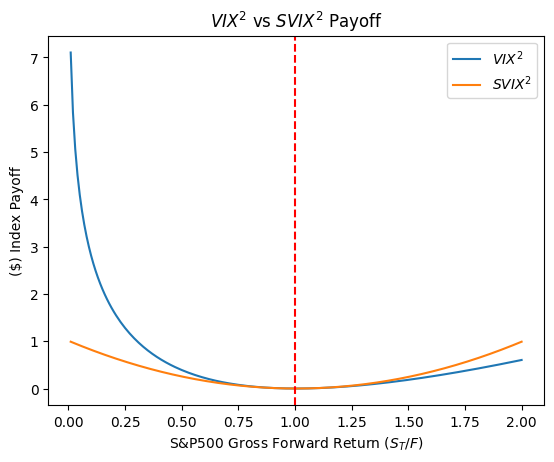

In [100]:
r=0.00
sigma,T,S0=0.3,1,1
t=0
num_strikes=1_000
dK=0.01
K=np.around( np.arange(0.01,num_strikes*dK+dK,dK) , 6 )
F=S0*np.exp(r*T)
#ST=np.arange(0.01,5+dK,dK)
ST=np.arange(0.01,2+dK,dK)
def payoff_func(F,K,ST):
    return np.where(F>=K,np.maximum(K-ST,0), np.maximum(ST-K,0)  )  

final_dict={}
for k in K:
    final_dict[k]={'r':r,'t':t}
    final_dict[k]['payoff']=payoff_func(F,k,ST)
    if k==F:
        final_dict[k]['type']='P/C Avg'
    elif k>F:
        final_dict[k]['type']='Call'
    elif k<F:
        final_dict[k]['type']='Put'
final_df=pd.DataFrame.from_dict(final_dict,orient='index')

vix_sqaure = (final_df.payoff.values * 2*dK/K**2).sum(axis=0)
svix_sqaure = (final_df.payoff.values * 2*dK/F**2).sum(axis=0)

#print(ST.shape)
#print(vix_sqaure.shape)

plt.plot( ST, vix_sqaure,label=r'$VIX^2$' )
plt.plot( ST, svix_sqaure,label=r'$SVIX^2$' )
plt.axvline(x=F,color='r', linestyle='--')
plt.title('$VIX^2$ vs $SVIX^2$ Payoff')
plt.ylabel('($) Index Payoff')
plt.xlabel('S&P500 Gross Forward Return ($S_T/F$)')
plt.legend()
plt.show()

In [660]:
#final_df.payoff.values / K**2
#K

#ST